In [1]:
import pandas as pd
import numpy as np
import csv
import scipy.optimize as sco
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_excel('/content/Factors_Prices.xlsx')
val = df['VALUE']
ben = df['BENCHMARK']
gro = df['GROWTH']
qual = df['QUALITY']
mom = df['MOMENTUM']
siz = df['SIZE']
Date = df['Date']

D = df[df['Date']=='2014-01-01'].index.values #Start of investments

df.pop('Date')
df.pop('BENCHMARK')

0       100.000000
1       101.119304
2       101.219494
3       101.706265
4       102.133819
           ...    
2605    573.668226
2606    568.546281
2607    564.377504
2608    570.479909
2609    568.171833
Name: BENCHMARK, Length: 2610, dtype: float64

We select a mooving window of 3*252=756 days

In [3]:
##########################################
#              Parameters                #
##########################################

F = 756  #Size of the Window
p = 90 #Numbers of days between rebalancements 

# **With absolute returns**

In [4]:
A = df.to_numpy()
m = 5
n = len(df)
ret = np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]

In [5]:
q = (n - F) // p #number of cycles for the optimization techniques

In [6]:
w_init = [0.15, 0.2, 0.25, 0.25, 0.15] #initial weights

w_MV=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Minimum variance
w_MD=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Maximum diversif
w_MS=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Maximum sharpe ratio
w_ER=[[0,0,0,0,0]]*(q+1) 
w_MV_exact=[[0,0,0,0,0]]*(q+1)
w_RP=[[0,0,0,0,0]]*(q+1)
w_EW = [[0.2,0.2,0.2,0.2,0.2]]*(q+1)
w_R=[[0,0,0,0,0]]*(q+1)
w_MC=[[0,0,0,0,0]]*(q+1)
w_N=[[0.25,0.25,0.25,0.25,0.25]]*(q+1)
cond_num = [[0]]*(q+1)


for i in range(q+1):
  ret_pd = pd.DataFrame(data=ret[0+i*p:F+i*p])
  cov_mat = ret_pd.cov()
  cov_mat = cov_mat.to_numpy()
  cor_mat = ret_pd.corr()
  cor_mat = cor_mat.to_numpy()
  sigma = np.sqrt(np.var(ret_pd))

#####################################################################
#               PORTFOLIO Minimum Variance                          #
#####################################################################

  def min_variance_fun(w, cov_mat):
      return w.T @ cov_mat @ w 

  def min_variance():
      cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
      bnds = [(0.1, 0.3) for k in range(len(w_init))]
      res = sco.minimize(fun = min_variance_fun, x0 = w_init, bounds = bnds, args = cov_mat,  method='trust-constr', tol = 10**(-6), constraints = cons, options = {'maxiter' : 100})
      return res

  #cov_mat1 = np.cov()
  w2 = min_variance().x
  w_MV[i] = w2

#####################################################################
#               PORTFOLIO Maximum diversification                   #
#####################################################################

  def max_diversification_fun(w, V):
      return w.T @ V @ w 

  def max_diversification():
      cons = ({'type': 'eq','fun': lambda x: np.sum(x) - 1})
      bnds = [(0.1, 0.3) for i in range(5)]
      res = sco.minimize(fun = max_diversification_fun, x0 = w_init, bounds = bnds, args = cor_mat, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return res

  MaxDiv = max_diversification()
  B = 0
  for j in range(5):
    B += MaxDiv.x[j]/sigma[j]

  w_MD[i] = [(MaxDiv.x[l]/sigma[l])/B for l in range(5)] 


#####################################################################
#               PORTFOLIO Maximum Sharpe Ratio                      #
#####################################################################

  def max_sharpe_fun(w, cov_mat):
      mu = [np.nanmean(ret[0+i*p:F+i*p][:,j])for j in range(5)]
      f = float(-(np.dot(np.transpose(w),mu)) / np.sqrt(np.dot(np.dot(np.transpose(w),cov_mat),w)))
      return f

  def max_sharpe():
      mu = [np.nanmean(ret[0+i*p:F+i*p][:,j]) for j in range(5)]
      cons = ({'type': 'eq',
             'fun': lambda x: np.sum(x) - 1})
      bounds = [(0.1,0.3) for k in range(len(w_init))]
      minimize = sco.minimize(fun = max_sharpe_fun, x0 = w_init, args = cov_mat, bounds=bounds, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return minimize

  w3 = max_sharpe().x
  w_MS[i] = w3

#####################################################################
#               PORTFOLIO Equal Risk Contribution                   #
#####################################################################

  def equal_risk_fun(w, cov_mat):
      f=0
      for i in range(5):
        for j in range(5):
            f += float((w[i]*np.dot(cov_mat,w)[i]-w[j]*np.dot(cov_mat,w)[j])**2)
      return f

  def equal_risk():
      cons = ({'type': 'eq',
             'fun': lambda x: np.sum(x) - 1})
      bounds = [(0.1, 0.3) for k in range(5)]
      minimize = sco.minimize(fun = equal_risk_fun, x0 = w_init, bounds=bounds, args=cov_mat, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return minimize

  w4 = equal_risk().x
  w_ER[i] = w4

#####################################################################
#               PORTFOLIO Risk Parity Method                        #
#####################################################################

  c = []
  d = 0
  for j in range(5):
    a = 1/(np.std(ret_pd.to_numpy()[:,j])*np.sqrt(252))
    c += [a]
    d += a
  for j in range(5):
    c[j] = c[j]/d

  w_RP[i] = c

#####################################################################
#               PORTFOLIO Minimum Correlation                       #
#####################################################################

  mean_cor = np.mean(cor_mat)
  standard_deviation_cor = np.std(cor_mat)

  d = norm(loc = mean_cor, scale = standard_deviation_cor)
  sh = np.shape(cor_mat)
  cor_adjusted = np.zeros(sh)
  for k in range(sh[0]):
    for j in range (sh[0]):
        cor_adjusted[k,j] = 1 - d.cdf(cor_mat[k,j])
  initial_weights = np.zeros(sh[0])
  for k in range (sh[0]):
    initial_weights[k] = np.mean(cor_adjusted[k,:])

  sum_ranks = sh[0]*(sh[0]+1)/2
  rank_weights = np.zeros(sh[0])

  listing = []
  for j in range (sh[0]):
    maxi = -1
    imax = 0
    for q in range(sh[0]):
        if initial_weights[q]>initial_weights[imax] and not q in listing:
            imax = q
            maxi = initial_weights[q]
    listing.append(imax)
    rank_weights[imax] = (sh[0]-j)/sum_ranks
  w1 = np.dot(rank_weights,cor_adjusted)
  w1_normalized = w1/np.sum(w1)
  w_5 = np.zeros(sh[0])
  for j in range (sh[0]):
    w_5[j] = w1_normalized[j]/np.sqrt(cov_mat[j,j])
  w_5 = w_5/np.sum(w_5)
  w_MC[i] = w_5

#####################################################################
#               RUSSELL Method                                      #
#####################################################################
  def ind(L,e):
    ind = 0
    for k in range(len(L)):
      if L[k] == e:
        ind = k
    return ind

  def rank_dec(L): #The biggest is ranked first
    S = sorted(L, reverse=True)
    rank = []
    for s in L:
      rank+= [ind(S,s)+1]
    return rank

  def rank_asc(L):
    S = sorted(L, reverse=False)
    rank = []
    for s in L:
      rank+= [ind(S,s)+1]
    return rank

  def rank_tot(L1,L2,L3):
    L = []
    for k in range(len(L1)):
      L += [rank_asc(L1)[k]+rank_asc(L2)[k]+rank_dec(L3)[k]]
    return rank_dec(L)
  

  #compute active semi-deviation
  asd=[0,0,0,0,0] 
  for j in range(5):
    avg=np.nanmean(ret_pd[j].to_numpy())
    s=0
    l=0
    for element in ret_pd[j].to_numpy():
      if element < avg:
        s+=(element-avg)**2
        l+=1
    if l==0:
      asd[j]=0
    else:
      asd[j]=np.sqrt(1/l*s)
  

  #compute correlation of excess returns
  corr=[0,0,0,0,0]
  for j in range(5):
    corr[j]=np.nanmean(cor_mat[j])

  #compute mean excess returns
  eret=[0,0,0,0,0]
  for j in range(5):
    eret[j]=np.nanmean(ret_pd[j].to_numpy())

  P=[0.3,0.25,0.20,0.15,0.1]
  
  def egal():
    L=[0,0,0,0,0]
    for h in range(5):
      L[rank_tot(asd,corr,eret)[h]-1]+=1
    return L

  L=egal()
  if L==[1]*5:
    w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]
  else: 
    for h in range(5):
      if L[h]==2:
        A_1=(P[h]+P[h-1])/2
        P[h-1]=A_1
        P[h]=A_1
        w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]
      elif L[h]==3:
        B=(P[h-1]+P[h-2]+P[h])/3
        P[h-1]=B
        P[h-2]=B
        P[h]=B
        w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]

#####################################################################
#               Nasdaq Method                                      #
#####################################################################
  n_1=F//p
  month_ret_fact_val=np.zeros((1,n_1))
  month_ret_fact_gro=np.zeros((1,n_1))
  month_ret_fact_qual=np.zeros((1,n_1))
  month_ret_fact_mom=np.zeros((1,n_1))
  month_ret_fact_siz=np.zeros((1,n_1))
  month_ret_ben=np.zeros((1,n_1))
  for k in range(n_1):
    month_ret_fact_val[0,k]=(val[0+i*p:F+i*p].values[(k+1)*p-1]-val[0+i*p:F+i*p].values[k*p])/(val[0+i*p:F+i*p].values[k*p])
    month_ret_fact_gro[0,k]=(gro[0+i*p:F+i*p].values[(k+1)*p-1]-gro[0+i*p:F+i*p].values[k*p])/(gro[0+i*p:F+i*p].values[k*p])
    month_ret_fact_qual[0,k]=(qual[0+i*p:F+i*p].values[(k+1)*p-1]-qual[0+i*p:F+i*p].values[k*p])/(qual[0+i*p:F+i*p].values[k*p])
    month_ret_fact_mom[0,k]=(mom[0+i*p:F+i*p].values[(k+1)*p-1]-mom[0+i*p:F+i*p].values[k*p])/(mom[0+i*p:F+i*p].values[k*p])
    month_ret_fact_siz[0,k]=(siz[0+i*p:F+i*p].values[(k+1)*p-1]-siz[0+i*p:F+i*p].values[k*p])/(siz[0+i*p:F+i*p].values[k*p])
    
    month_ret_ben[0,k]=(ben[0+i*p:F+i*p].values[(k+1)*p-1]-ben[0+i*p:F+i*p].values[k*p])/(ben[0+i*p:F+i*p].values[k*p])
  
  LR_1=LinearRegression()
  LR_1.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_val.reshape(-1, 1))
  LR_1.coef_
  C_1=LR_1.intercept_
  LR_2=LinearRegression()
  LR_2.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_gro.reshape(-1, 1))
  LR_2.coef_
  C_2=LR_2.intercept_
  LR_3=LinearRegression()
  LR_3.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_qual.reshape(-1, 1))
  LR_3.coef_
  C_3=LR_3.intercept_
  LR_4=LinearRegression()
  LR_4.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_mom.reshape(-1, 1))
  LR_4.coef_
  C_4=LR_4.intercept_
  LR_5=LinearRegression()
  LR_5.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_siz.reshape(-1, 1))
  LR_5.coef_
  C_5=LR_5.intercept_
  H=[C_1,C_2,C_3,C_4,C_5]
  w_N[i]=np.array([0.25]*ind(H,min(H))+[0]+[0.25]*(4-ind(H,min(H))))


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

In [7]:
#####################################################################
#               PORTFOLIO Benchmark                                 #
#####################################################################

ret_Ben=[0]*(len(ben[F:])-1)
ben= 100*ben.to_numpy()/float(ben.to_numpy()[D])
for i in range(len(ret_Ben)-1):
  ret_Ben[i]=(ben[i+F]-ben[i+F-1])/ben[i+F-1]

return_ben=((ben[len(ben)-1]/ben[int(D)])**(1/7)-1)*100

meanvolatilityben=(np.std(ret_Ben[int(D-F):])*np.sqrt(252))*100


#####################################################################
#               PORTFOLIO Values and Returns                        #
#####################################################################

Q = int(D-F)

def value_vol_ret(w):
  value_mat=np.zeros((2610-F,6)) 
  value_mat[0][:5]=np.array(w)[0]*100
  value_mat[0][5]=100
  for i in range(F+1, n):
    for k in range(5):
      value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k]) # avec ret les absolute returns journaliers de chaque facteur
    value_mat[i-F][5]=sum(value_mat[i-F][:5])
    if (i-F)%p==0: #c'est les jours de rebalancement
      value_mat[i-F][:5]=value_mat[i-F][5]*np.array(w)[(i-F)//p]
  values=value_mat[:,-1]
  values=100 * values / values[Q]

  ret_=[0]*(len(values)-1)
  for i in range(len(ret_)):
    ret_[i]=(values[i]-values[i-1])/values[i-1]

  returns=(((values[-1])/values[D-F])**(1/7)-1)*100
  meanvolatility=(np.std(ret_[int(D-F):])*np.sqrt(252))*100
  Beta=np.cov(ret_Ben,ret_)[0][1]/np.cov(ret_Ben,ret_)[0][0] #Calcul du Beta du portefeuille
  Shpe=returns/meanvolatility # Calcul ratio de Sharpe
  treyn=returns/(100*Beta) #Calcul ratio de Treynor

  return values, returns, meanvolatility, Beta, treyn, Shpe

value_EW,return_EW,meanvolatilityEW,Beta_EW,Treyn_EW, sharpe_EW = value_vol_ret(w_EW)
value_MS,return_MS,meanvolatilityMS,Beta_MS,Treyn_MS, sharpe_MS = value_vol_ret(w_MS)
value_MV,return_MV,meanvolatilityMV,Beta_MV,Treyn_MV, sharpe_MV = value_vol_ret(w_MV)
value_MD,return_MD,meanvolatilityMD,Beta_MD,Treyn_MD, sharpe_MD = value_vol_ret(w_MD)
value_ER,return_ER,meanvolatilityER,Beta_ER,Treyn_ER, sharpe_ER = value_vol_ret(w_ER)
value_RP,return_RP,meanvolatilityRP,Beta_RP,Treyn_RP, sharpe_RP = value_vol_ret(w_RP)
value_MC,return_MC,meanvolatilityMC,Beta_MC,Treyn_MC, sharpe_MC = value_vol_ret(w_MC)
value_R,return_R,meanvolatilityR,Beta_R,Treyn_R, sharpe_R = value_vol_ret(w_R)
value_N,return_N,meanvolatilityN,Beta_N,Treyn_N, sharpe_N = value_vol_ret(w_N)



In [8]:
gap_ret_EW=[100*(value_EW[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_EW))]
gap_ret_MS=[100*(value_MS[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MS))]
gap_ret_MV=[100*(value_MV[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MV))]
gap_ret_MD=[100*(value_MD[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MD))]
gap_ret_ER=[100*(value_ER[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_ER))]
gap_ret_RP=[100*(value_RP[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_RP))]
gap_ret_MC=[100*(value_MC[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MC))]
gap_ret_R=[100*(value_R[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_R))]
gap_ret_N=[100*(value_N[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_N))]

In [9]:
####################################################################
#                     Moving Average Filter                        #
####################################################################

def moving_average(x, window):
  avg = np.zeros(len(x))
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  avg[0] = x[0]
  for i in range(1, window):
    avg[i] = ((cumsum[i:] - cumsum[:-i]) / float(i)) [0]
  temp = (cumsum[window:] - cumsum[:-window]) / float(window)
  return np.concatenate((avg[1:window], temp), axis=None)

window = 75; #3 months

value_ben_avg = moving_average(np.asarray(ben), window)
value_EW_avg = moving_average(np.asarray(value_EW), window)
value_MS_avg = moving_average(np.asarray(value_MS), window)
value_MV_avg = moving_average(np.asarray(value_MV), window)
value_MD_avg = moving_average(np.asarray(value_MD), window)
value_ER_avg = moving_average(np.asarray(value_ER), window)
value_RP_avg = moving_average(np.asarray(value_RP), window)
value_MC_avg = moving_average(np.asarray(value_MC), window)
value_R_avg = moving_average(np.asarray(value_R), window)
value_N_avg = moving_average(np.asarray(value_N), window)

gap_ret_EW_avg = moving_average(np.asarray(gap_ret_EW), window)
gap_ret_MS_avg = moving_average(np.asarray(gap_ret_MS), window)
gap_ret_MV_avg = moving_average(np.asarray(gap_ret_MV), window)
gap_ret_MD_avg = moving_average(np.asarray(gap_ret_MD), window)
gap_ret_ER_avg = moving_average(np.asarray(gap_ret_ER), window)
gap_ret_RP_avg = moving_average(np.asarray(gap_ret_RP), window)
gap_ret_MC_avg = moving_average(np.asarray(gap_ret_MC), window)
gap_ret_R_avg = moving_average(np.asarray(gap_ret_R), window)
gap_ret_N_avg = moving_average(np.asarray(gap_ret_N), window)

In [10]:
#computation of random portfolios: 

import itertools
ret_list=[]
vol_list=[]
sharpe_list=[]
for j in range(1000):
  w=np.random.rand(5)
  w=w/sum(w)
  a=np.random.uniform(0,1)
  b=np.random.uniform(0,1-a)
  c=np.random.uniform(0,1-(a+b))
  d=np.random.uniform(0,1-(a+b+c))
  e=1-(a+b+c+d)
  w=np.array([[a,b,c,d,e],[e,d,c,b,a]]) #On a pris la liste inverse pour pas donner trop de poids au premier facteur. Etude proba a monté que c'était bien comme ca
  for elemt in w: 
    value_mat = np.zeros((2610-F,6)) 
    value_mat[0][:5]=np.array(elemt)*100
    value_mat[0][5]=100

    for i in range(F+1, n):
      for k in range(5):
        value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k])
      value_mat[i-F][5]=sum(value_mat[i-F][:5])
      if (i-F)%p==0:
        value_mat[i-F][:5]=value_mat[i-F][5]*np.array(elemt)
      value=value_mat[:,-1]

    return_=[0]*(len(value)-1)
    for i in range(len(value)-1):
      return_[i]=(value[i+1]-value[i])/value[i]



    retn=(((value[-1])/value[D-F])**(1/7)-1)*100 

    meanvolatility=(np.std(return_[int(D-F):])*np.sqrt(252))*100
    ret_list+=[retn]
    vol_list+=[meanvolatility]
    sharpe_list+=[retn/meanvolatility]

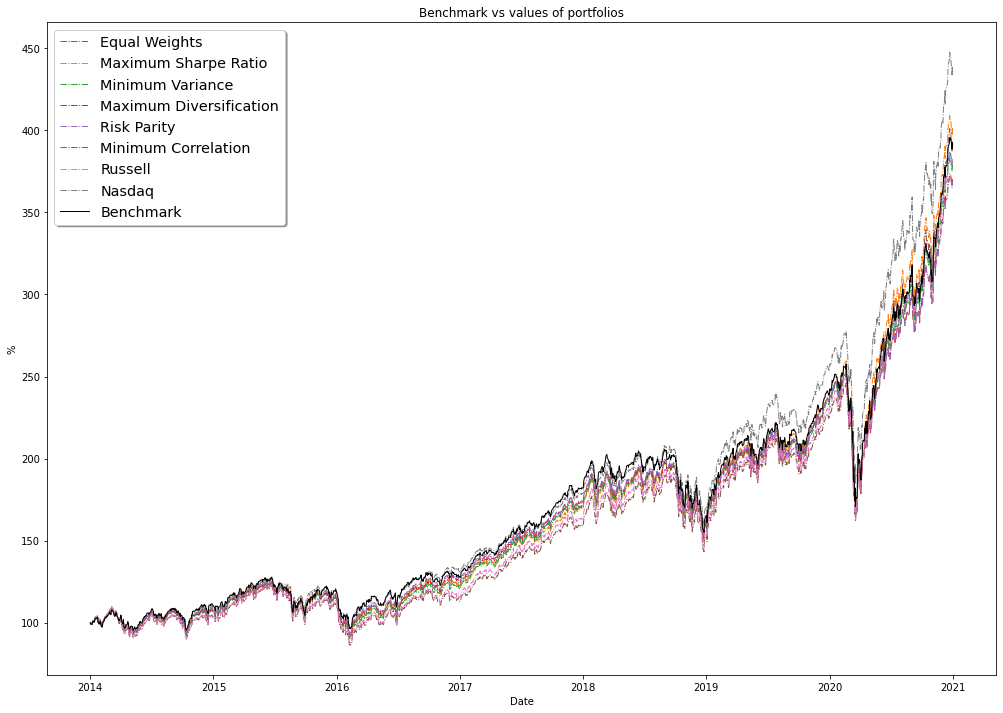

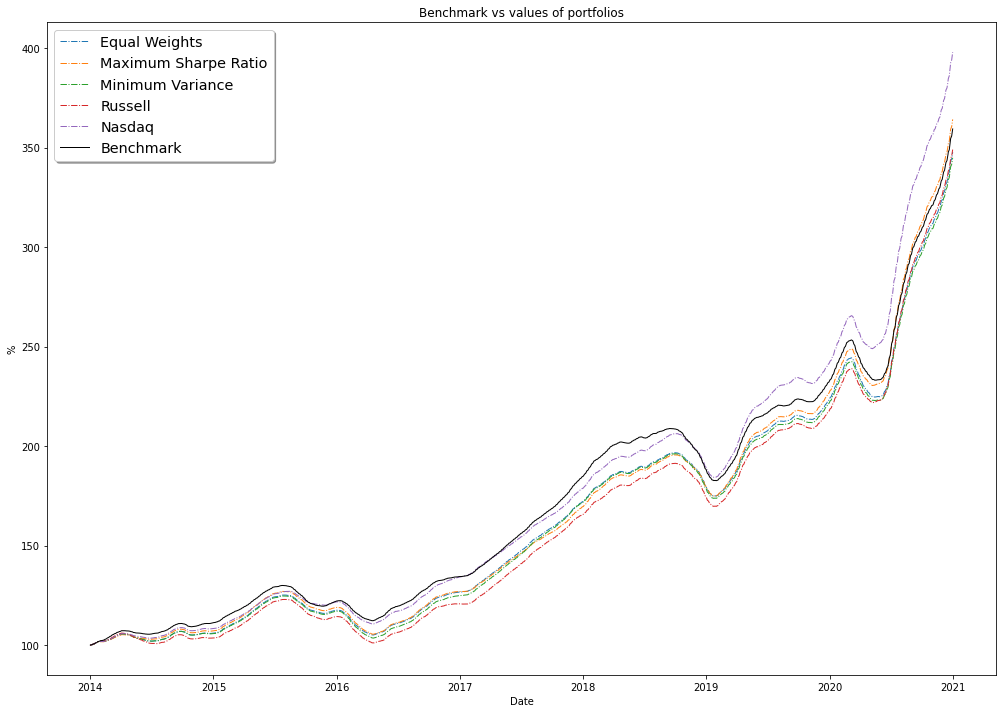

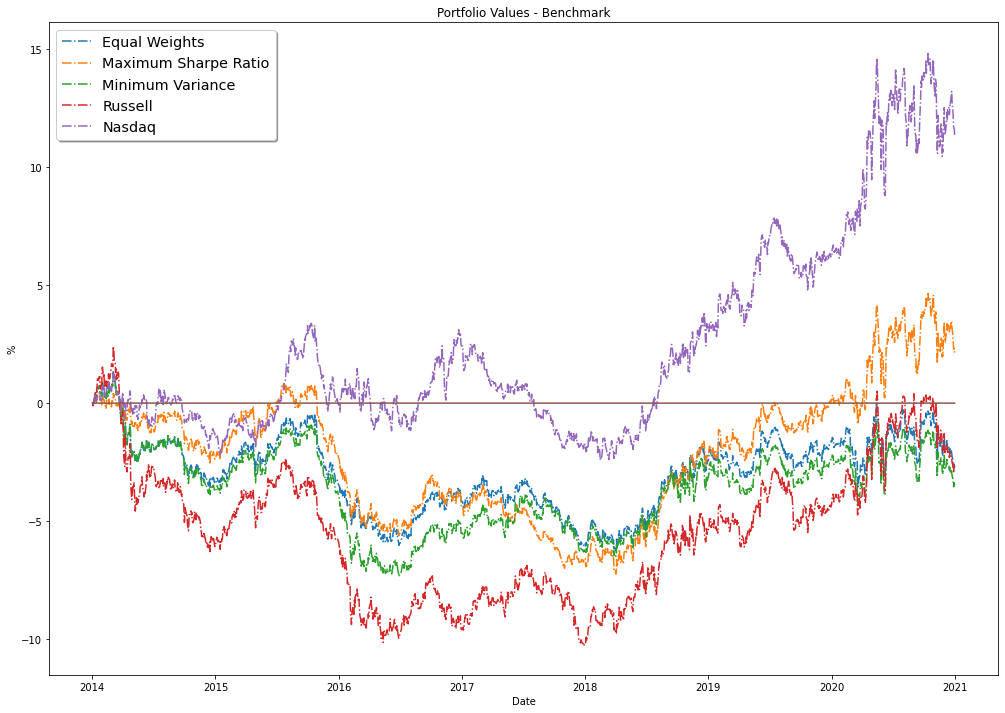

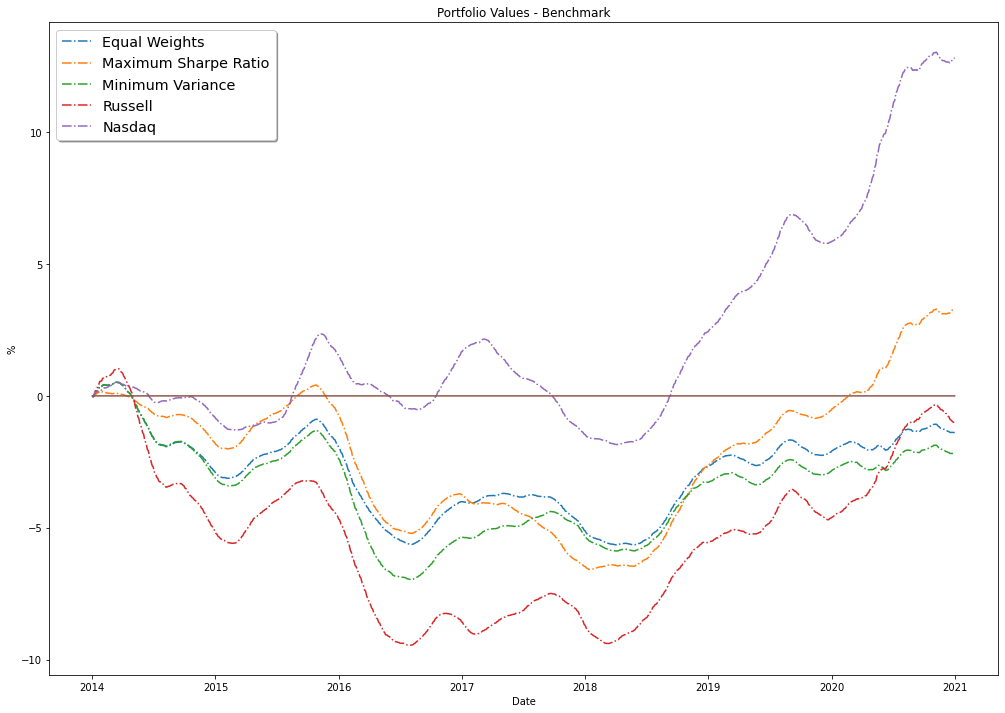

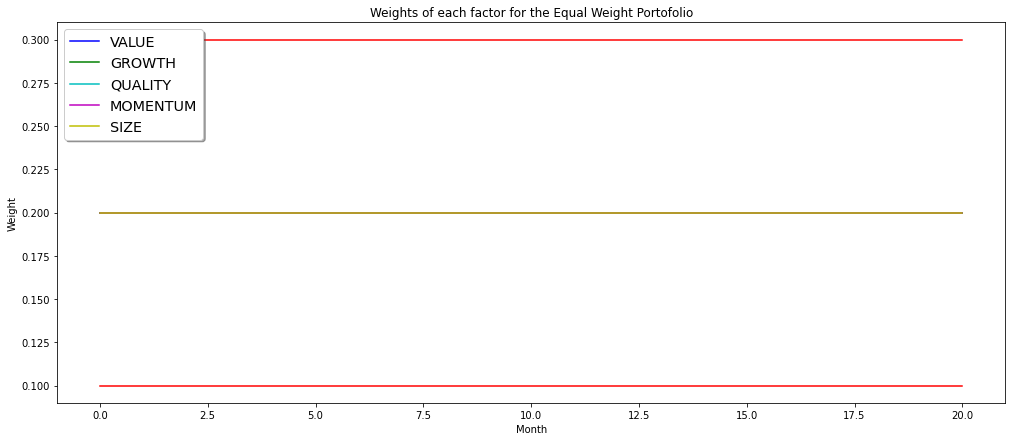

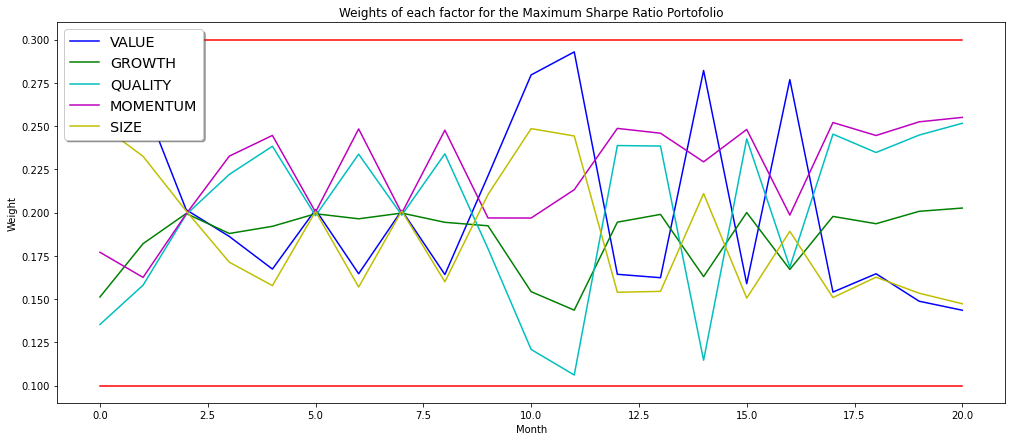

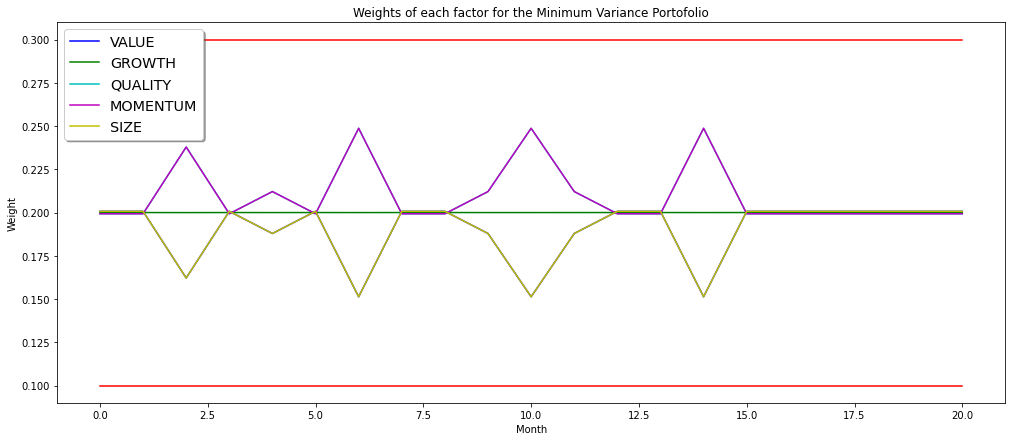

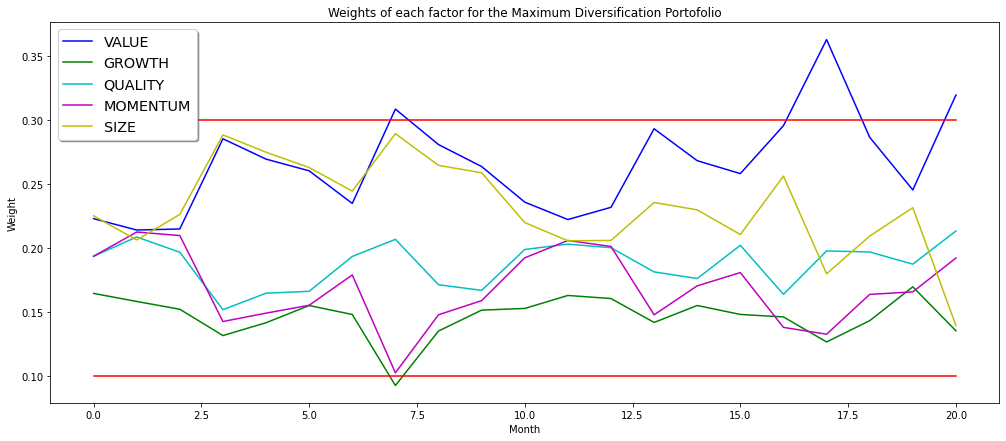

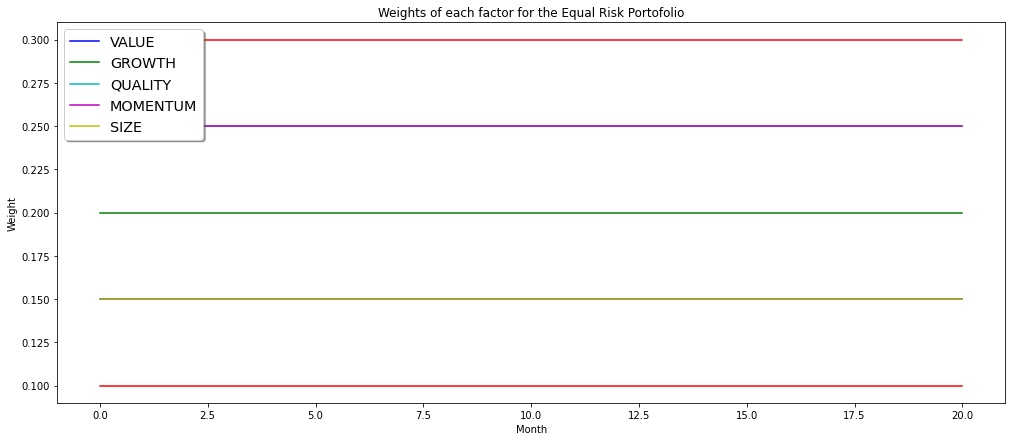

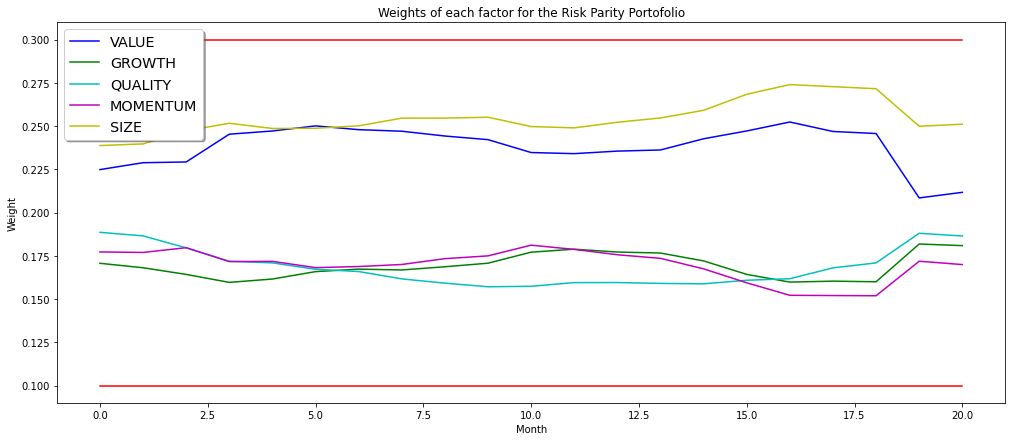

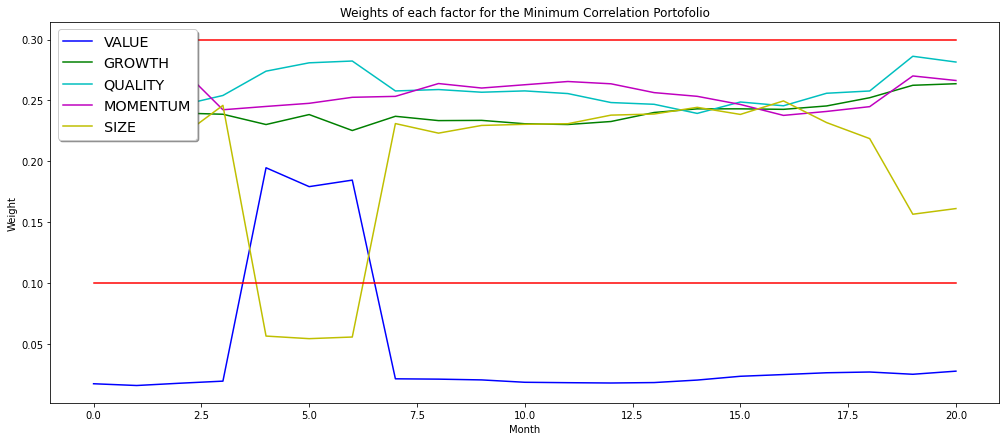

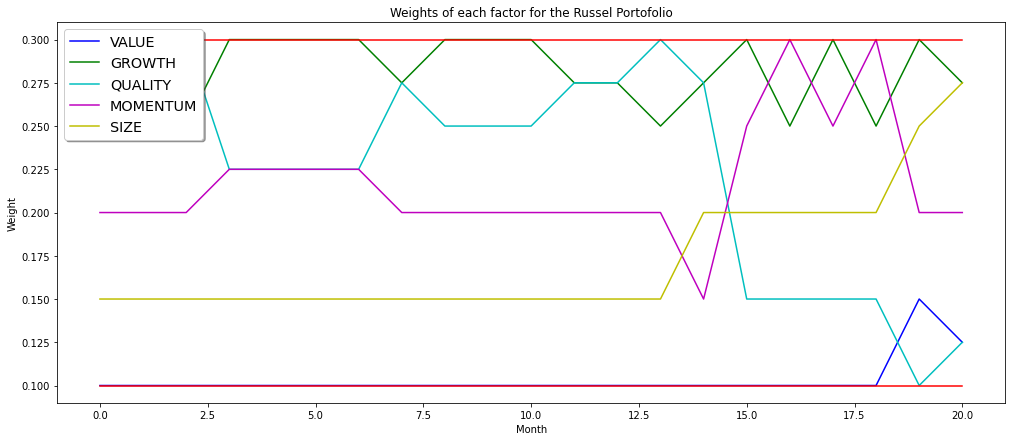

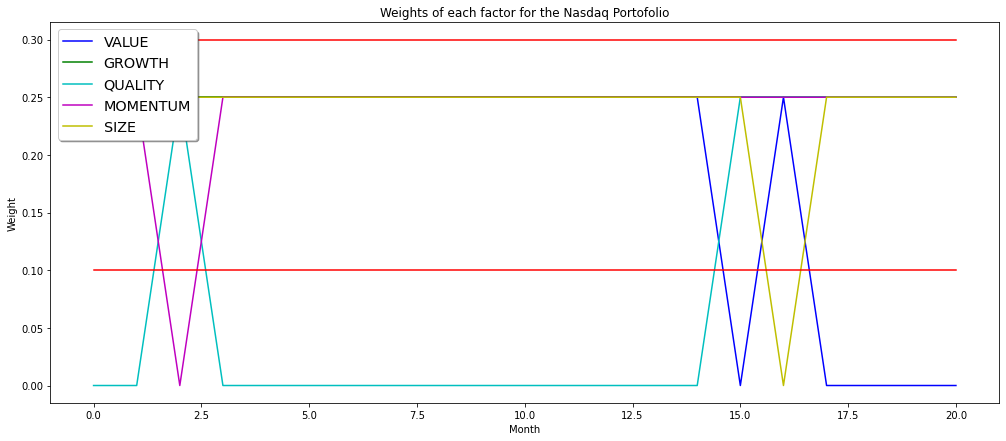

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


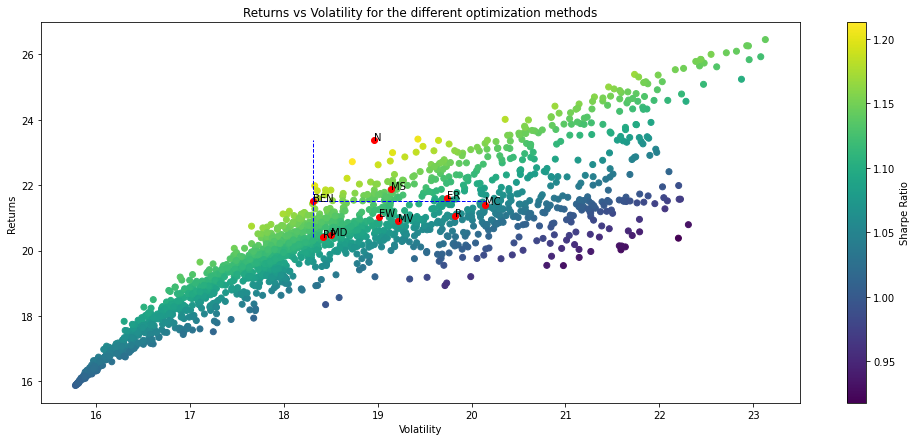

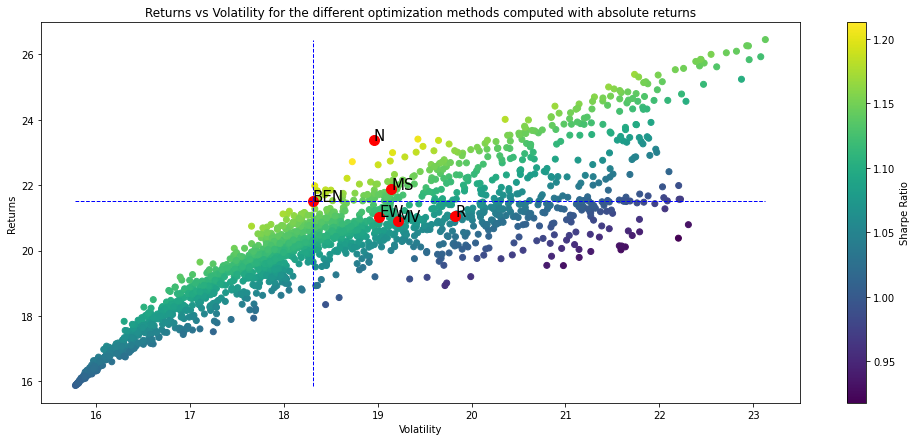

EQUAL WEIGHT PORTFOLIO:  Annualized returns= [21.03942715] % ; Annualized volatility= 19.013861266896708 % ;Sharpe ratio= [1.10653101] ;Treynor ratio= [0.2030338] ;Beta= 1.0362524363931471
MAXIMUM SHARPE RATIO PORTFOLIO:  Annualized returns= [21.86894642] % ; Annualized volatility= 19.142278349292752 % Sharpe ratio= [1.14244219] Treynor ratio= [0.21021742] ;Beta= 1.0403013220314699
MINIMUM VARIANCE PORTFOLIO:  Annualized returns= [20.89866143] % ; Annualized volatility= 19.211590416827352 % Sharpe ratio= [1.08781527] Treynor ratio= [0.19984338] Beta= 1.0457519763799235
MAXIMUM DIVERSIFICATION PORTFOLIO:  Annualized returns= [20.47775269] % ; Annualized volatility= 18.497050245151126 % Sharpe ratio= [1.10708207] Treynor ratio= [0.20276568] Beta= 1.0099220495671513
EQUAL RISK PORTFOLIO:  Annualized returns= [21.60344603] % ; Annualized volatility= 19.737926682984963 % Sharpe ratio= [1.09451445] Treynor ratio= [0.20196116] Beta= 1.069683224653964
RISK PARITY PORTFOLIO:  Annualized returns

In [11]:
import matplotlib.pyplot as plt

####################################################################
#      GRAPHS: Plot the price of portofolio, normalized to 100     #
####################################################################

D = int(D)
fig, ax = plt.subplots(figsize = (17, 12)) #No moving average filter
ax.plot(Date[D:], value_EW[Q:], '-.', linewidth = 1, label = 'Equal Weights') #Equal Weights
ax.plot(Date[D:], value_MS[Q:], '-.', linewidth = 1, label = 'Maximum Sharpe Ratio') #Sharpe Ratio
ax.plot(Date[D:], value_MV[Q:], '-.', linewidth = 1, label = 'Minimum Variance') #Minimum Variance
ax.plot(Date[D:], value_MD[Q:], '-.', linewidth = 1, label = 'Maximum Diversification') #Maximum Diversification
#ax.plot(Date[D:], value_ER[Q:], '-.', linewidth = 1, label = 'Equal Risk') #Equal Risk
ax.plot(Date[D:], value_RP[Q:], '-.', linewidth = 1, label = 'Risk Parity') #Risk Parity
ax.plot(Date[D:], value_MC[Q:], '-.', linewidth = 1, label = 'Minimum Correlation') #Minimum Correlation
ax.plot(Date[D:], value_R[Q:], '-.', linewidth = 1, label = 'Russell') #Russell
ax.plot(Date[D:], value_N[Q:], '-.', linewidth = 1, label = 'Nasdaq') #Nasdaq
ax.plot(Date[D:], ben[D:2610], 'k', linewidth = 1, label = 'Benchmark') #Benchmark

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Benchmark vs values of portfolios')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

fig, ax = plt.subplots(figsize = (17, 12)) #Moving average filter
ax.plot(Date[D:], 100 * value_EW_avg[Q:] / value_EW_avg[Q], '-.', linewidth = 1, label = 'Equal Weights') #Equal Weights
ax.plot(Date[D:], 100 * value_MS_avg[Q:] / value_MS_avg[Q], '-.', linewidth = 1, label = 'Maximum Sharpe Ratio') #Sharpe Ratio
ax.plot(Date[D:], 100 * value_MV_avg[Q:] / value_MV_avg[Q], '-.', linewidth = 1, label = 'Minimum Variance') #Minimum Variance
#ax.plot(Date[D:], 100 * value_MD_avg[Q:] / value_MD_avg[Q], '-.', linewidth = 1, label = 'Maximum Diversification') #Maximum Diversification
#ax.plot(Date[D:], 100 * value_ER_avg[Q:] / value_ER_avg[Q], '-.', linewidth = 1, label = 'Equal Risk') #Equal Risk
#ax.plot(Date[D:], 100 * value_RP_avg[Q:] / value_RP_avg[Q], '-.', linewidth = 1, label = 'Risk Parity') #Risk Parity
#ax.plot(Date[D:], 100 * value_MC_avg[Q:] / value_MC_avg[Q], '-.', linewidth = 1, label = 'Minimum Correlation') #Minimum Correlation
ax.plot(Date[D:], 100 * value_R_avg[Q:] / value_R_avg[Q], '-.', linewidth = 1, label = 'Russell') #Russell
ax.plot(Date[D:], 100 * value_N_avg[Q:] / value_N_avg[Q], '-.', linewidth = 1, label = 'Nasdaq') #Nasdaq
ax.plot(Date[D:], 100 * value_ben_avg[D:2610] / value_ben_avg[D], 'k', linewidth = 1, label = 'Benchmark') #Benchmark

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Benchmark vs values of portfolios')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

####################################################################
#      GRAPHS: Plot the difference to the benchmark                #
####################################################################

fig, ax = plt.subplots(figsize = (17, 12)) #No moving average filter
ax.plot(Date[D:], gap_ret_EW, '-.', label = 'Equal Weights')
ax.plot(Date[D:], gap_ret_MS, '-.', label = 'Maximum Sharpe Ratio')
ax.plot(Date[D:], gap_ret_MV, '-.', label = 'Minimum Variance')
#ax.plot(Date[D:], gap_ret_MD, '-.', label = 'Maximum Diversification')
#ax.plot(Date[F:], [100*(value_ER[i] - ben[i + F])/ben[i + F] for i in range(len(value_ER))], '-.', label = 'Equal Risk')
#ax.plot(Date[D:], gap_ret_RP, '-.', label = 'Risk Parity')
#ax.plot(Date[D:], gap_ret_MC, '-.', label = 'Minimum Correlation')
ax.plot(Date[D:], gap_ret_R, '-.', label = 'Russell')
ax.plot(Date[D:], gap_ret_N, '-.', label = 'Nasdaq')
ax.plot(Date[D: ], [0 for i in range(len(Date[D: ]))])

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Portfolio Values - Benchmark')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

fig, ax = plt.subplots(figsize = (17, 12)) #Moving average filter
ax.plot(Date[D:], gap_ret_EW_avg, '-.', label = 'Equal Weights')
ax.plot(Date[D:], gap_ret_MS_avg, '-.', label = 'Maximum Sharpe Ratio')
ax.plot(Date[D:], gap_ret_MV_avg, '-.', label = 'Minimum Variance')
#ax.plot(Date[D:], gap_ret_MD_avg, '-.', label = 'Maximum Diversification')
#ax.plot(Date[F:], [100*(value_ER[i] - ben[i + F])/ben[i + F] for i in range(len(value_ER))], '-.', label = 'Equal Risk')
#ax.plot(Date[D:], gap_ret_RP_avg, '-.', label = 'Risk Parity')
#ax.plot(Date[D:], gap_ret_MC_avg, '-.', label = 'Minimum Correlation')
ax.plot(Date[D:], gap_ret_R_avg, '-.', label = 'Russell')
ax.plot(Date[D:], gap_ret_N_avg, '-.', label = 'Nasdaq')
ax.plot(Date[D: ], [0 for i in range(len(Date[D: ]))])

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Portfolio Values - Benchmark')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

######################################################################
# GRAPHS: Evolution of the weights of each factor per each technique #
######################################################################

titles = ['Weights of each factor for the Equal Weight Portofolio',
          'Weights of each factor for the Maximum Sharpe Ratio Portofolio',
          'Weights of each factor for the Minimum Variance Portofolio',
          'Weights of each factor for the Maximum Diversification Portofolio',
          'Weights of each factor for the Equal Risk Portofolio',
          'Weights of each factor for the Risk Parity Portofolio',
          'Weights of each factor for the Minimum Correlation Portofolio',
          'Weights of each factor for the Russel Portofolio',
          'Weights of each factor for the Nasdaq Portofolio']

colors = ['b', 'g', 'c', 'm', 'y', 'k']

factors = ['VALUE', 'GROWTH', 'QUALITY', 'MOMENTUM', 'SIZE']

w_EW = np.array(w_EW)
w_MS = np.array(w_MS)
w_MV = np.array(w_MV)
w_MD = np.array(w_MD)
w_ER = np.array(w_ER)
w_RP = np.array(w_RP)
w_MC = np.array(w_MC)
w_R = np.array(w_R)
w_N = np.array(w_N)
f=len(w_MS)
w = np.ndarray(shape = (len(titles), f, 5)) # avant 75 c'était 104
w[0] = w_EW
w[1] = w_MS
w[2] = w_MV
w[3] = w_MD
w[4] = w_ER
w[5] = w_RP
w[6] = w_MC
w[7] = w_R
w[8] = w_N
Months = [i for i in range(f)]

for j in range(len(titles)):
    fig, ax = plt.subplots(figsize=(17, 7))
    for i in range(5):
        ax.plot(Months, w[j, :, i], colors[i], label=factors[i])
    plt.ylabel('Weight')
    plt.xlabel('Month')
    plt.title(titles[j])
    plt.plot(Months,[0.1 for i in range(f)], 'r')
    plt.plot(Months,[0.3 for i in range(f)], 'r')
    ax.legend(loc='upper left', shadow = True, fontsize='x-large')

plt.show()

####################################################################
#      GRAPHS: Annualized Returns vs Volatility Scatter            #
####################################################################

returns = [return_MS, return_MD, return_MV, return_RP, return_EW, return_MC, return_ben, return_R, return_N, return_ER]
meanVolatilities = [meanvolatilityMS, meanvolatilityMD, meanvolatilityMV, meanvolatilityRP, meanvolatilityEW, meanvolatilityMC, meanvolatilityben, meanvolatilityR, meanvolatilityN, meanvolatilityER]
#returns = [return_MS, return_MV, return_MC, return_ben, return_R, return_N]
#meanVolatilities = [meanvolatilityMS, meanvolatilityMV, meanvolatilityMC, meanvolatilityben, meanvolatilityR, meanvolatilityN]
xy_line = (meanvolatilityben, return_ben)
plt.subplots(figsize=(17, 7))
plt.scatter(vol_list,ret_list, c=sharpe_list, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(meanVolatilities, returns, color='red')
plt.ylabel('Returns')
plt.xlabel('Volatility')
plt.title('Returns vs Volatility for the different optimization methods')
plt.hlines(return_ben, min(meanVolatilities), max(meanVolatilities), 'b', linestyles='dashed', linewidth = 1)
plt.vlines(meanvolatilityben, min(returns), max(returns), 'b', linestyles='dashed', linewidth = 1)
labels = ['MS', 'MD', 'MV', 'RP', 'EW', 'MC', 'BEN', 'R', 'N', 'ER']
#labels = ['MS', 'MV', 'MC', 'BEN', 'R', 'N']
for i in range (len(meanVolatilities)):
  plt.annotate(labels[i], (meanVolatilities[i], returns[i]))


plt.show()

#returns = [return_MS, return_MD, return_MV, return_RP, return_EW, return_MC, return_ben, return_R, return_N, return_ER]
#meanVolatilities = [meanvolatilityMS, meanvolatilityMD, meanvolatilityMV, meanvolatilityRP, meanvolatilityEW, meanvolatilityMC, meanvolatilityben, meanvolatilityR, meanvolatilityN, meanvolatilityER]
returns = [return_MS, return_MV, return_EW, return_ben, return_R, return_N]
meanVolatilities = [meanvolatilityMS, meanvolatilityMV, meanvolatilityEW, meanvolatilityben, meanvolatilityR, meanvolatilityN]
xy_line = (meanvolatilityben, return_ben)
plt.subplots(figsize=(17, 7))
plt.scatter(vol_list,ret_list, c=sharpe_list, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(meanVolatilities, returns, color='red',s=100)
plt.ylabel('Returns')
plt.xlabel('Volatility')
plt.title('Returns vs Volatility for the different optimization methods computed with absolute returns')
plt.hlines(return_ben, min(vol_list), max(vol_list), 'b', linestyles='dashed', linewidth = 1)
plt.vlines(meanvolatilityben, min(ret_list), max(ret_list), 'b', linestyles='dashed', linewidth = 1)
#labels = ['MS', 'MD', 'MV', 'RP', 'EW', 'MC', 'BEN', 'R', 'N', 'ER']
labels = ['MS', 'MV', 'EW', 'BEN', 'R', 'N']
for i in range (len(meanVolatilities)):
  plt.annotate(labels[i], (meanVolatilities[i], returns[i]),size=15)


plt.show()

####################################################################
#      PRINt: Annualized Returns and Annualized Volatilities       #
####################################################################

print('EQUAL WEIGHT PORTFOLIO: ', 'Annualized returns=', return_EW, '%', '; Annualized volatility=', meanvolatilityEW, '%',';Sharpe ratio=',sharpe_EW, ';Treynor ratio=',Treyn_EW,';Beta=',Beta_EW)
print('MAXIMUM SHARPE RATIO PORTFOLIO: ','Annualized returns=', return_MS, '%', '; Annualized volatility=', meanvolatilityMS, '%','Sharpe ratio=',sharpe_MS, 'Treynor ratio=',Treyn_MS,';Beta=',Beta_MS)
print('MINIMUM VARIANCE PORTFOLIO: ','Annualized returns=', return_MV, '%', '; Annualized volatility=', meanvolatilityMV, '%','Sharpe ratio=',sharpe_MV, 'Treynor ratio=',Treyn_MV,'Beta=',Beta_MV)
print('MAXIMUM DIVERSIFICATION PORTFOLIO: ','Annualized returns=', return_MD, '%', '; Annualized volatility=', meanvolatilityMD, '%','Sharpe ratio=',sharpe_MD, 'Treynor ratio=',Treyn_MD,'Beta=',Beta_MD)
print('EQUAL RISK PORTFOLIO: ','Annualized returns=', return_ER, '%', '; Annualized volatility=', meanvolatilityER, '%','Sharpe ratio=',sharpe_ER, 'Treynor ratio=',Treyn_ER,'Beta=',Beta_ER)
print('RISK PARITY PORTFOLIO: ','Annualized returns=', return_RP, '%', '; Annualized volatility=', meanvolatilityRP, '%','Sharpe ratio=',sharpe_RP, 'Treynor ratio=',Treyn_RP,'Beta=',Beta_RP)
print('MINIMUM CORRELATION PORTFOLIO: ','Annualized returns=', return_MC, '%', '; Annualized volatility=', meanvolatilityMC, '%','Sharpe ratio=',sharpe_MC, 'Treynor ratio=',Treyn_MC,'Beta=',Beta_MC)
print('RUSSEL PORTFOLIO: ','Annualized returns=', return_R, '%', '; Annualized volatility=', meanvolatilityR, '%','Sharpe ratio=',sharpe_R, 'Treynor ratio=',Treyn_R,'Beta=',Beta_R)
print('NASDAQ PORTFOLIO: ','Annualized returns=', return_N, '%', '; Annualized volatility=', meanvolatilityN, '%','Sharpe ratio=',sharpe_N, 'Treynor ratio=',Treyn_N,'Beta=',Beta_N)

#**With Relative returns**

In [12]:
 df = pd.read_excel('/content/Factors_Prices.xlsx')
 ben=df['BENCHMARK']
 df.pop('Date')
 df.pop('BENCHMARK')

0       100.000000
1       101.119304
2       101.219494
3       101.706265
4       102.133819
           ...    
2605    573.668226
2606    568.546281
2607    564.377504
2608    570.479909
2609    568.171833
Name: BENCHMARK, Length: 2610, dtype: float64

In [13]:
A = df.to_numpy()
m = 5
n = len(df)
ret = np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]
rel_ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    rel_ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]-(ben[i]-ben[i-1])/ben[i-1]

In [14]:
q = (n - F) // p

In [15]:
w_init = [0.15, 0.2, 0.25, 0.25, 0.15]

w_MV=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Minimum variance
w_MD=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Maximum diversif
w_MS=[[0,0,0,0,0]]*(q+1) # This is the history of all the lists of weights during the whole period of study for Maximum sharpe ratio
w_ER=[[0,0,0,0,0]]*(q+1) 
w_MV_exact=[[0,0,0,0,0]]*(q+1)
w_RP=[[0,0,0,0,0]]*(q+1)
w_EW = [[0.2,0.2,0.2,0.2,0.2]]*(q+1)
w_R=[[0,0,0,0,0]]*(q+1)
w_MC=[[0,0,0,0,0]]*(q+1)
w_N=[[0.25,0.25,0.25,0.25,0.25]]*(q+1)
cond_num = [[0]]*(q+1)


for i in range(q+1):
  rel_ret_pd = pd.DataFrame(data=rel_ret[0+i*p:F+i*p])
  cov_mat = rel_ret_pd.cov()
  cov_mat = cov_mat.to_numpy()
  cor_mat = rel_ret_pd.corr()
  cor_mat = cor_mat.to_numpy()
  sigma = np.sqrt(np.var(rel_ret_pd))

#####################################################################
#               PORTFOLIO Minimum Variance                          #
#####################################################################

  def min_variance_fun(w, cov_mat):
      return np.matmul(np.matmul(w.T, cov_mat),w)

  def min_variance():
      cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1}) #{'type': 'ineq', 'fun': lambda x: x - low_bound}, {'type': 'ineq', 'fun': lambda x: -x + up_bound})
      bnds = [(0.1, 0.3) for k in range(len(w_init))]
      res = sco.minimize(fun = min_variance_fun, x0 = w_init, bounds = bnds, args = cov_mat,  method='trust-constr', tol = 10**(-6), constraints = cons, options = {'maxiter' : 100})
      return res

  w2 = min_variance().x
  w_MV[i] = w2

#####################################################################
#               PORTFOLIO Maximum diversification                   #
#####################################################################

  def max_diversification_fun(w, V):
      return w.T @ V @ w 

  def max_diversification():
      cons = ({'type': 'eq','fun': lambda x: np.sum(x) - 1})
      bnds = [(0.1, 0.3) for i in range(5)]
      res = sco.minimize(fun = max_diversification_fun, x0 = w_init, bounds = bnds, args = cor_mat, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return res

  MaxDiv = max_diversification()
  B=0
  for j in range(5):
    B += MaxDiv.x[j]/sigma[j]

  w_MD[i] = [(MaxDiv.x[l]/sigma[l])/B for l in range(5)] 

#####################################################################
#               PORTFOLIO Minimum Variance Exact                    #
#####################################################################
  cond_num[i] = np.linalg.cond(cov_mat)
  cov_inverted = np.linalg.inv(cov_mat)
  cor_inverted = np.linalg.inv(cor_mat)
  vec_ones = np.ones(5).T 
  w_MV_exact[i] = np.dot(cov_inverted, vec_ones)/(np.dot(np.dot(vec_ones.T,cov_inverted),vec_ones)) 

#####################################################################
#               PORTFOLIO Maximum Sharpe Ratio                      #
#####################################################################

  def max_sharpe_fun(w, cov_mat):
      mu = [np.nanmean(rel_ret[0+i*p:F+i*p][:,j])for j in range(5)]
      f = float(-(np.dot(np.transpose(w),mu)) / np.sqrt(np.dot(np.dot(np.transpose(w),cov_mat),w)))
      return f

  def max_sharpe():
      mu = [np.nanmean(rel_ret[0+i*p:F+i*p][:,j]) for j in range(5)]
      cons = ({'type': 'eq',
             'fun': lambda x: np.sum(x) - 1})
      bounds = [(0.1,0.3) for k in range(len(w_init))]
      minimize = sco.minimize(fun = max_sharpe_fun, x0 = w_init, args = cov_mat, bounds=bounds, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return minimize

  w3 = max_sharpe().x
  w_MS[i] = w3

#####################################################################
#               PORTFOLIO Equal Risk Contribution                   #
#####################################################################

  def equal_risk_fun(w, cov_mat):
      f=0
      for i in range(5):
        for j in range(5):
            f += float((w[i]*np.dot(cov_mat,w)[i]-w[j]*np.dot(cov_mat,w)[j])**2)
      return f

  def equal_risk():
      cons = ({'type': 'eq',
             'fun': lambda x: np.sum(x) - 1})
      bounds = [(0.1, 0.3) for k in range(5)]
      minimize = sco.minimize(fun = equal_risk_fun, x0 = w_init, bounds=bounds, args=cov_mat, method='trust-constr', tol = 10**(-6), constraints=cons, options = {'maxiter' : 100})
      return minimize

  w4 = equal_risk().x
  w_ER[i] = w4

#####################################################################
#               PORTFOLIO Risk Parity Method                        #
#####################################################################

  c = []
  d = 0
  for j in range(5):
    a = 1/(np.std(rel_ret_pd.to_numpy()[:,j])*np.sqrt(252))
    c += [a]
    d += a
  for j in range(5):
    c[j] = c[j]/d

  w_RP[i] = c

#####################################################################
#               PORTFOLIO Minimum Correlation                       #
#####################################################################

  mean_cor = np.mean(cor_mat)
  standard_deviation_cor = np.std(cor_mat)

  d = norm(loc = mean_cor, scale = standard_deviation_cor)
  sh = np.shape(cor_mat)
  cor_adjusted = np.zeros(sh)
  for k in range(sh[0]):
    for j in range (sh[0]):
        cor_adjusted[k,j] = 1 - d.cdf(cor_mat[k,j])

  initial_weights = np.zeros(sh[0])
  for k in range (sh[0]):
    initial_weights[k] = np.mean(cor_adjusted[k,:])

  sum_ranks = sh[0]*(sh[0]+1)/2
  rank_weights = np.zeros(sh[0])

  listing = []
  for j in range (sh[0]):
    maxi = -1
    imax = 0
    for q in range(sh[0]):
        if initial_weights[q]>initial_weights[imax] and not q in listing:
            imax = q
            maxi = initial_weights[q]
    listing.append(imax)
    rank_weights[imax] = (sh[0]-j)/sum_ranks
  w1 = np.dot(rank_weights,cor_adjusted)
  w1_normalized = w1/np.sum(w1)
  w_5 = np.zeros(sh[0])
  for j in range (sh[0]):
    w_5[j] = w1_normalized[j]/np.sqrt(cov_mat[j,j])
  w_5 = w_5/np.sum(w_5)
  w_MC[i] = w_5

#####################################################################
#               RUSSELL Method                                      #
#####################################################################
  def ind(L,e):
    ind = 0
    for k in range(len(L)):
      if L[k] == e:
        ind = k
    return ind

  def rank_dec(L): #The biggest is ranked first
    S = sorted(L, reverse=True)
    rank = []
    for s in L:
      rank+= [ind(S,s)+1]
    return rank

  def rank_asc(L):
    S = sorted(L, reverse=False)
    rank = []
    for s in L:
      rank+= [ind(S,s)+1]
    return rank

  def rank_tot(L1,L2,L3):
    L = []
    for k in range(len(L1)):
      L += [rank_asc(L1)[k]+rank_asc(L2)[k]+rank_dec(L3)[k]]
    return rank_dec(L)
  

  #compute active semi-deviation
  asd=[0,0,0,0,0] 
  for j in range(5):
    avg=np.nanmean(rel_ret_pd[j].to_numpy())
    s=0
    l=0
    for element in rel_ret_pd[j].to_numpy():
      if element < avg:
        s+=(element-avg)**2
        l+=1
    if l==0:
      asd[j]=0
    else:
      asd[j]=np.sqrt(1/l*s)
  

  #compute correlation of excess returns
  corr=[0,0,0,0,0]
  for j in range(5):
    corr[j]=np.nanmean(cor_mat[j])

  #compute mean excess returns
  eret=[0,0,0,0,0]
  for j in range(5):
    eret[j]=np.nanmean(rel_ret_pd[j].to_numpy())

  P=[0.3,0.25,0.20,0.15,0.1]
  
  def egal():
    L=[0,0,0,0,0]
    for h in range(5):
      L[rank_tot(asd,corr,eret)[h]-1]+=1
    return L

  L=egal()
  #print(L)
  if L==[1]*5:
    w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]
  else: 
    for h in range(5):
      if L[h]==2:
        A_1=(P[h]+P[h-1])/2
        P[h-1]=A_1
        P[h]=A_1
        w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]
      elif L[h]==3:
        B=(P[h-1]+P[h-2]+P[h])/3
        P[h-1]=B
        P[h-2]=B
        P[h]=B
        w_R[i]=[P[k-1] for k in rank_tot(asd,corr,eret)]

#####################################################################
#               Nasdaq Method                                      #
#####################################################################
  n_1=F//p
  month_ret_fact_val=np.zeros((1,n_1))
  month_ret_fact_gro=np.zeros((1,n_1))
  month_ret_fact_qual=np.zeros((1,n_1))
  month_ret_fact_mom=np.zeros((1,n_1))
  month_ret_fact_siz=np.zeros((1,n_1))
  month_ret_ben=np.zeros((1,n_1))
  for k in range(n_1):
    month_ret_fact_val[0,k]=(val[0+i*p:F+i*p].values[(k+1)*p-1]-val[0+i*p:F+i*p].values[k*p])/(val[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_gro[0,k]=(gro[0+i*p:F+i*p].values[(k+1)*p-1]-gro[0+i*p:F+i*p].values[k*p])/(gro[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_qual[0,k]=(qual[0+i*p:F+i*p].values[(k+1)*p-1]-qual[0+i*p:F+i*p].values[k*p])/(qual[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_mom[0,k]=(mom[0+i*p:F+i*p].values[(k+1)*p-1]-mom[0+i*p:F+i*p].values[k*p])/(mom[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_siz[0,k]=(siz[0+i*p:F+i*p].values[(k+1)*p-1]-siz[0+i*p:F+i*p].values[k*p])/(siz[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_ben[0,k]=(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
  
  LR_1=LinearRegression()
  LR_1.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_val.reshape(-1, 1))
  LR_1.coef_
  C_1=LR_1.intercept_
  LR_2=LinearRegression()
  LR_2.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_gro.reshape(-1, 1))
  LR_2.coef_
  C_2=LR_2.intercept_
  LR_3=LinearRegression()
  LR_3.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_qual.reshape(-1, 1))
  LR_3.coef_
  C_3=LR_3.intercept_
  LR_4=LinearRegression()
  LR_4.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_mom.reshape(-1, 1))
  LR_4.coef_
  C_4=LR_4.intercept_
  LR_5=LinearRegression()
  LR_5.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_siz.reshape(-1, 1))
  LR_5.coef_
  C_5=LR_5.intercept_
  H=[C_1,C_2,C_3,C_4,C_5]
  w_N[i]=np.array([0.25]*ind(H,min(H))+[0]+[0.25]*(4-ind(H,min(H))))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

In [16]:
#####################################################################
#               PORTFOLIO Benchmark                                 #
#####################################################################

ret_Ben=[0]*(len(ben[F:])-1)
ben= 100*ben.to_numpy()/float(ben.to_numpy()[D])
for i in range(len(ret_Ben)-1):
  ret_Ben[i]=(ben[i+F]-ben[i+F-1])/ben[i+F-1]

return_ben=((ben[len(ben)-1]/ben[int(D)])**(1/7)-1)*100

meanvolatilityben=(np.std(ret_Ben[int(D-F):])*np.sqrt(252))*100


#####################################################################
#               PORTFOLIO Values and Returns                        #
#####################################################################

Q = int(D-F)

def value_vol_ret(w):
  value_mat=np.zeros((2610-F,6)) 
  value_mat[0][:5]=np.array(w)[0]*100
  value_mat[0][5]=100
  for i in range(F+1, n):
    for k in range(5):
      value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k]) # avec ret les absolute returns journaliers de chaque facteur
    value_mat[i-F][5]=sum(value_mat[i-F][:5])
    if (i-F)%p==0: #c'est les jours de rebalancement
      value_mat[i-F][:5]=value_mat[i-F][5]*np.array(w)[(i-F)//p]
  values=value_mat[:,-1]
  values=100 * values / values[Q]

  ret_=[0]*(len(values)-1)
  for i in range(len(ret_)):
    ret_[i]=(values[i]-values[i-1])/values[i-1]

  returns=(((values[-1])/values[D-F])**(1/7)-1)*100
  meanvolatility=(np.std(ret_[int(D-F):])*np.sqrt(252))*100
  Beta=np.cov(ret_Ben,ret_)[0][1]/np.cov(ret_Ben,ret_)[0][0] #Calcul du Beta du portefeuille
  Shpe=returns/meanvolatility # Calcul ratio de Sharpe
  treyn=returns/(100*Beta) #Calcul ratio de Treynor

  return values, returns, meanvolatility, Beta, treyn, Shpe

value_EW,return_EW,meanvolatilityEW,Beta_EW,Treyn_EW, sharpe_EW = value_vol_ret(w_EW)
value_MS,return_MS,meanvolatilityMS,Beta_MS,Treyn_MS, sharpe_MS = value_vol_ret(w_MS)
value_MV,return_MV,meanvolatilityMV,Beta_MV,Treyn_MV, sharpe_MV = value_vol_ret(w_MV)
value_MD,return_MD,meanvolatilityMD,Beta_MD,Treyn_MD, sharpe_MD = value_vol_ret(w_MD)
value_ER,return_ER,meanvolatilityER,Beta_ER,Treyn_ER, sharpe_ER = value_vol_ret(w_ER)
value_RP,return_RP,meanvolatilityRP,Beta_RP,Treyn_RP, sharpe_RP = value_vol_ret(w_RP)
value_MC,return_MC,meanvolatilityMC,Beta_MC,Treyn_MC, sharpe_MC = value_vol_ret(w_MC)
value_R,return_R,meanvolatilityR,Beta_R,Treyn_R, sharpe_R = value_vol_ret(w_R)
value_N,return_N,meanvolatilityN,Beta_N,Treyn_N, sharpe_N = value_vol_ret(w_N)

In [17]:
gap_ret_EW=[100*(value_EW[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_EW))]
gap_ret_MS=[100*(value_MS[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MS))]
gap_ret_MV=[100*(value_MV[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MV))]
gap_ret_MD=[100*(value_MD[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MD))]
gap_ret_ER=[100*(value_ER[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_ER))]
gap_ret_RP=[100*(value_RP[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_RP))]
gap_ret_MC=[100*(value_MC[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_MC))]
gap_ret_R=[100*(value_R[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_R))]
gap_ret_N=[100*(value_N[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_N))]

In [18]:
####################################################################
#                     Moving Average Filter                        #
####################################################################

def moving_average(x, window):
  avg = np.zeros(len(x))
  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  avg[0] = x[0]
  for i in range(1, window):
    avg[i] = ((cumsum[i:] - cumsum[:-i]) / float(i)) [0]
  temp = (cumsum[window:] - cumsum[:-window]) / float(window)
  return np.concatenate((avg[1:window], temp), axis=None)

window = 75; #3 months

value_ben_avg = moving_average(np.asarray(ben), window)
value_EW_avg = moving_average(np.asarray(value_EW), window)
value_MS_avg = moving_average(np.asarray(value_MS), window)
value_MV_avg = moving_average(np.asarray(value_MV), window)
value_MD_avg = moving_average(np.asarray(value_MD), window)
value_ER_avg = moving_average(np.asarray(value_ER), window)
value_RP_avg = moving_average(np.asarray(value_RP), window)
value_MC_avg = moving_average(np.asarray(value_MC), window)
value_R_avg = moving_average(np.asarray(value_R), window)
value_N_avg = moving_average(np.asarray(value_N), window)

gap_ret_EW_avg = moving_average(np.asarray(gap_ret_EW), window)
gap_ret_MS_avg = moving_average(np.asarray(gap_ret_MS), window)
gap_ret_MV_avg = moving_average(np.asarray(gap_ret_MV), window)
gap_ret_MD_avg = moving_average(np.asarray(gap_ret_MD), window)
gap_ret_ER_avg = moving_average(np.asarray(gap_ret_ER), window)
gap_ret_RP_avg = moving_average(np.asarray(gap_ret_RP), window)
gap_ret_MC_avg = moving_average(np.asarray(gap_ret_MC), window)
gap_ret_R_avg = moving_average(np.asarray(gap_ret_R), window)
gap_ret_N_avg = moving_average(np.asarray(gap_ret_N), window)

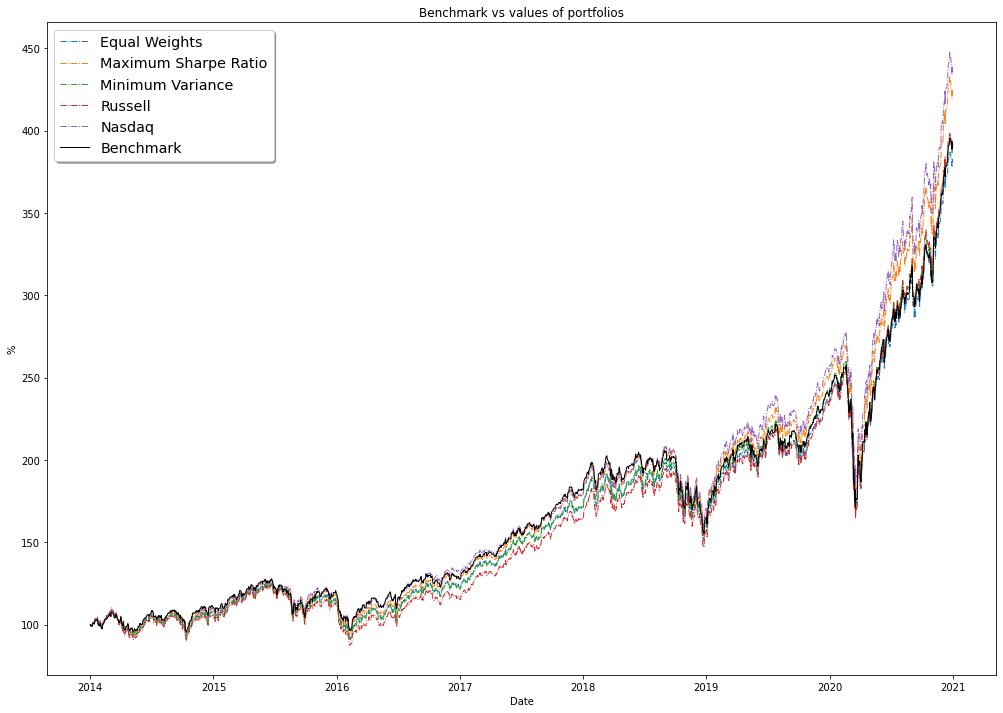

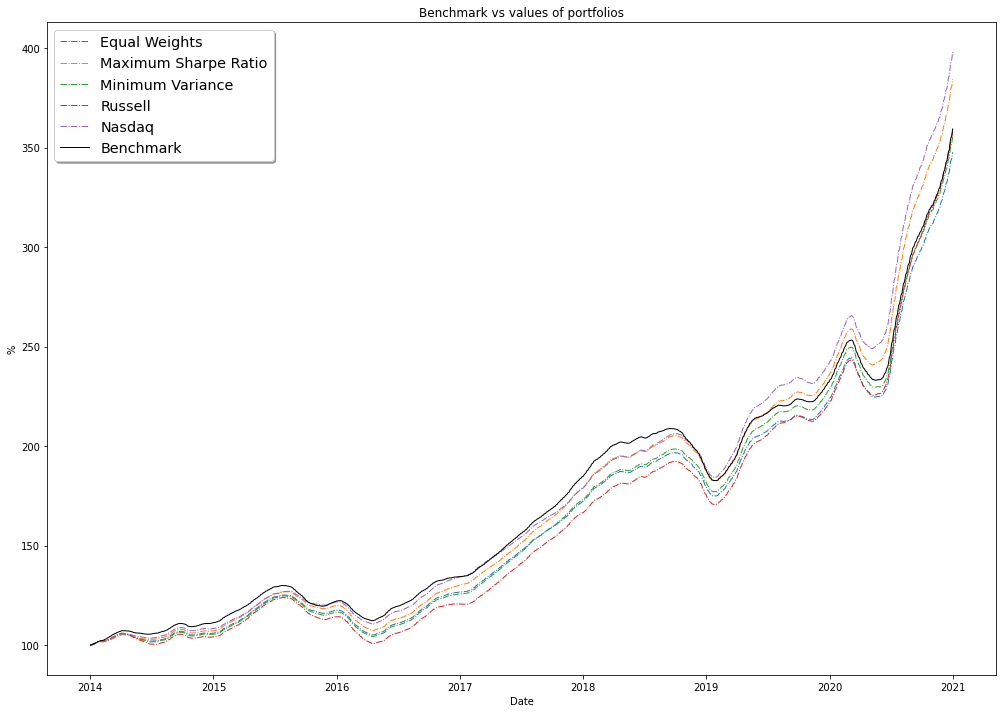

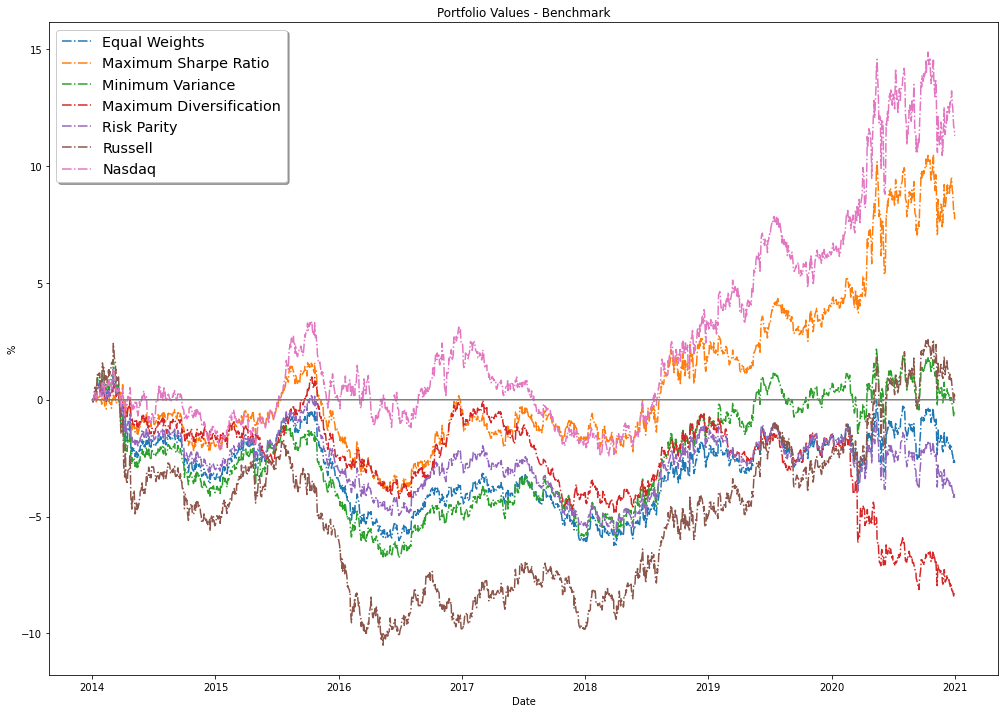

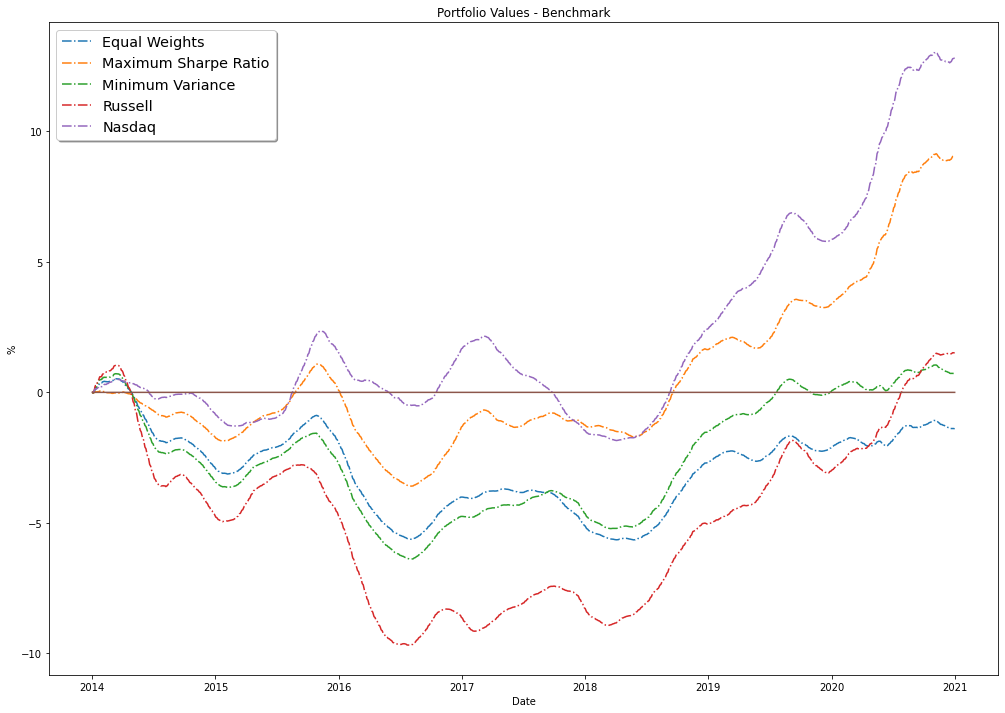

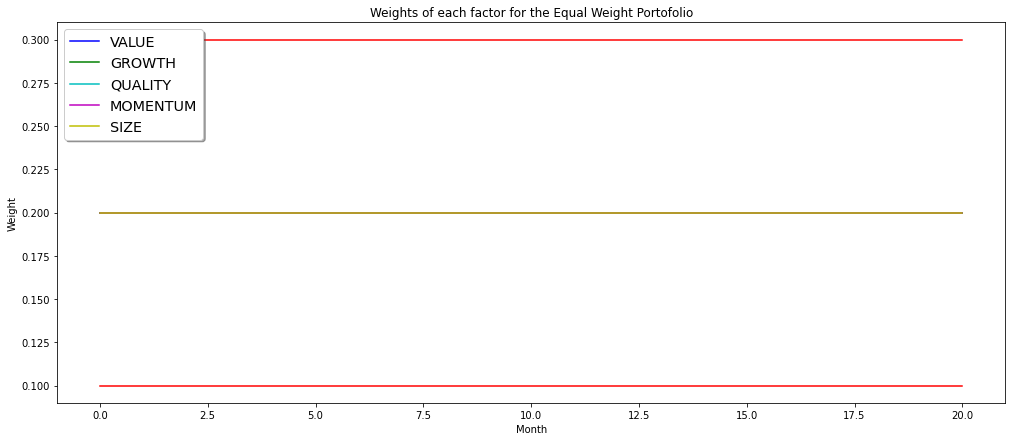

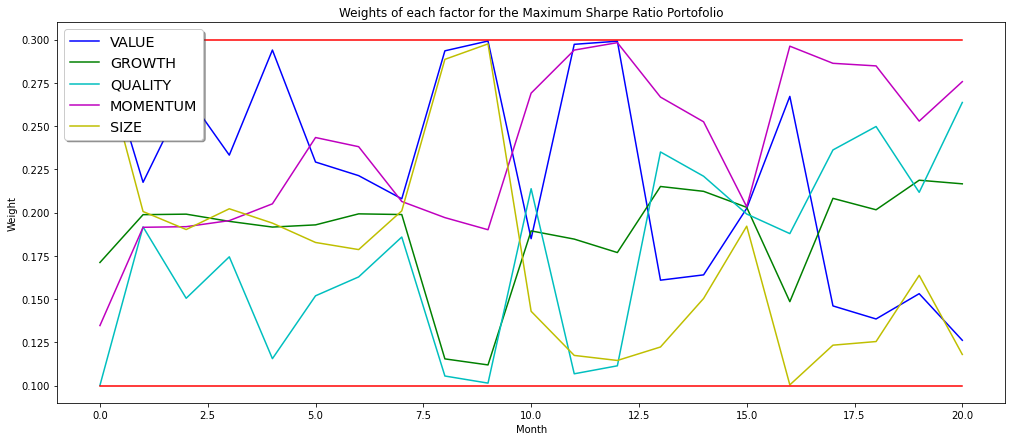

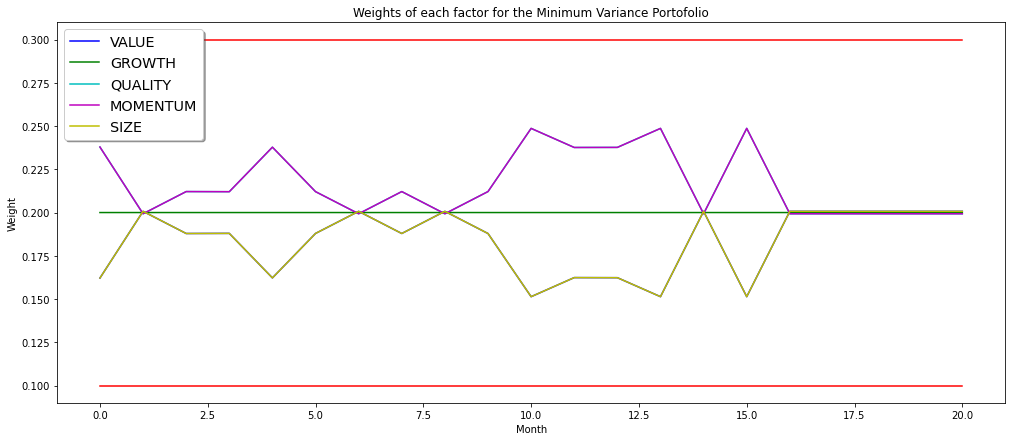

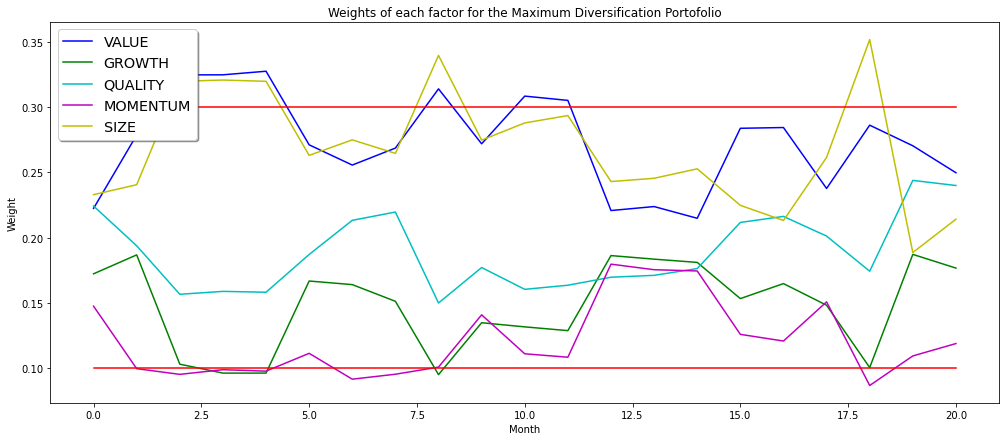

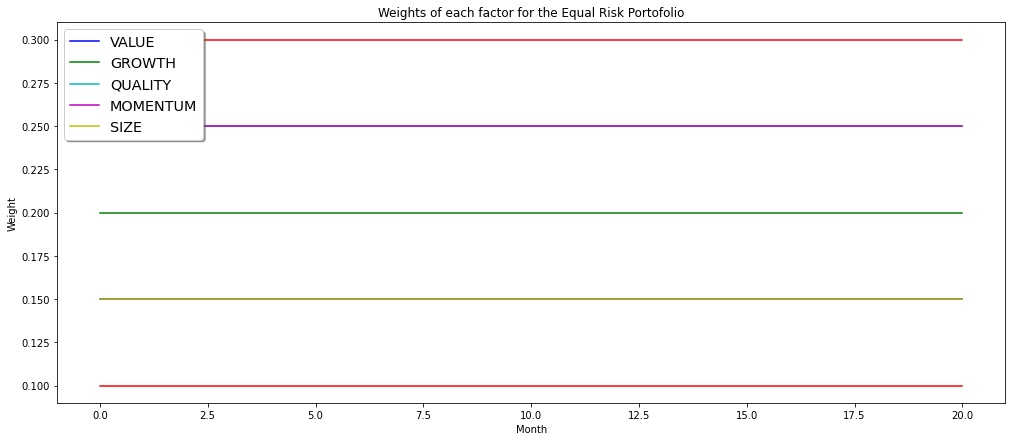

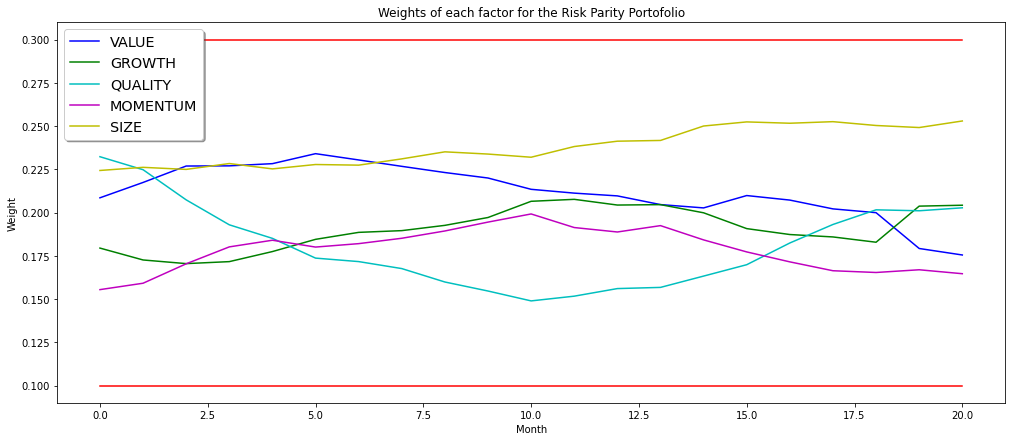

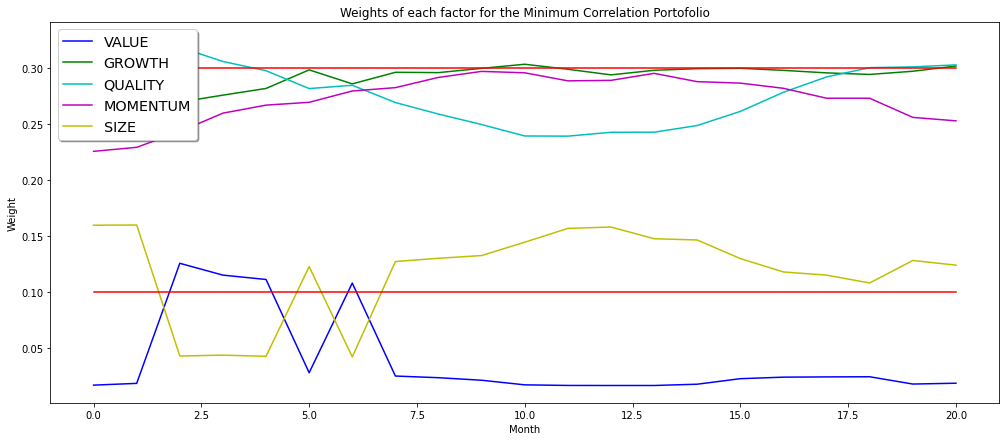

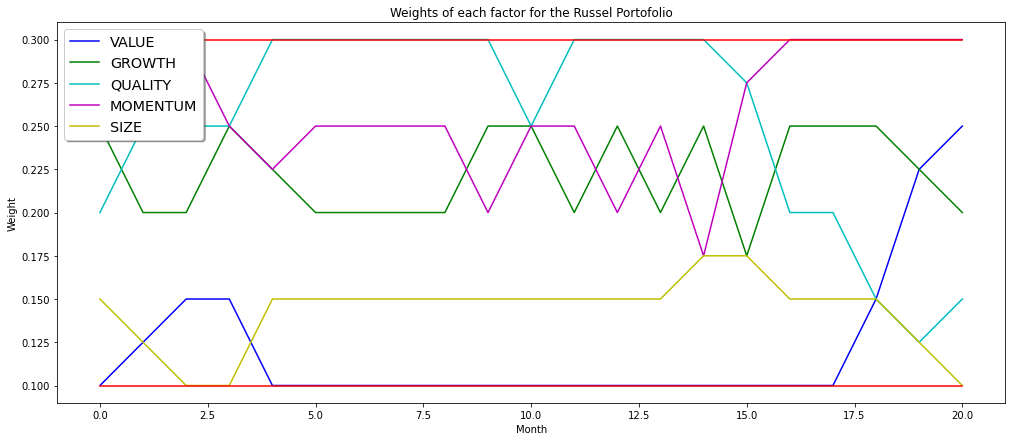

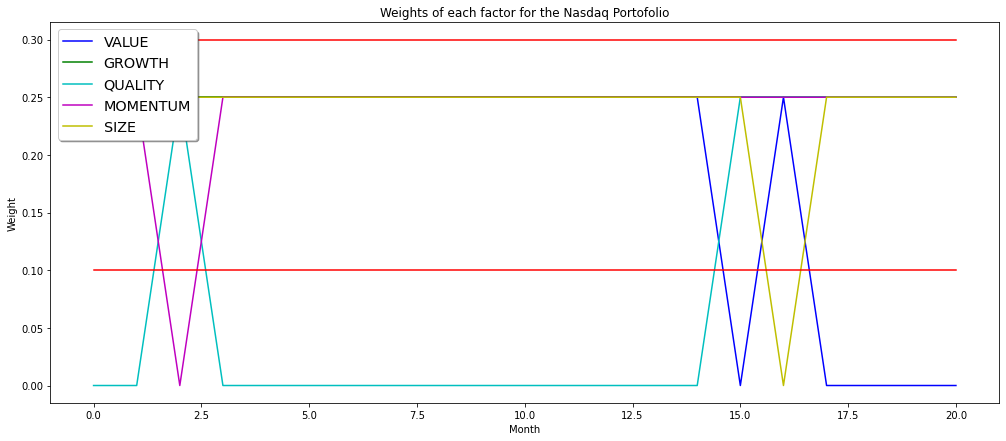

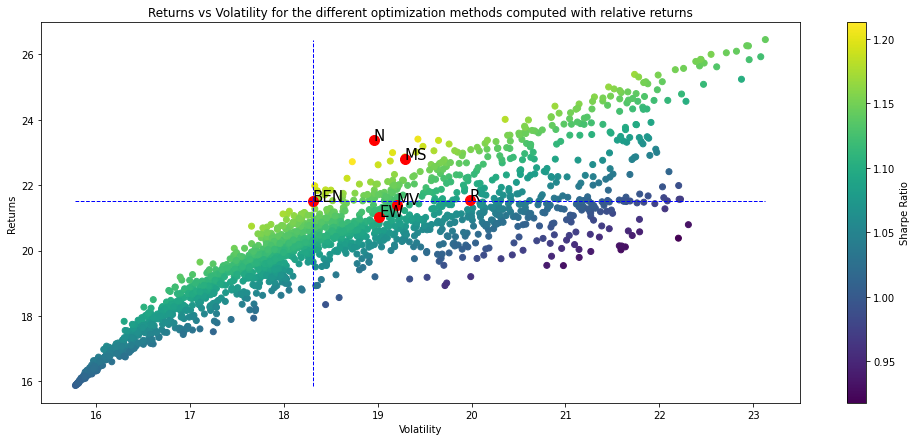

EQUAL WEIGHT PORTFOLIO:  Annualized returns= 21.03942715347582 % ; Annualized volatility= 19.013861266896708 % Sharpe ratio= 1.106531012199276 % Treynor ratio= 0.20303380155811382 % Beta= 1.0362524363931471 %
MAXIMUM SHARPE RATIO PORTFOLIO:  Annualized returns= 22.81243624064395 % ; Annualized volatility= 19.2890529393961 % Sharpe ratio= 1.182662327296104 % Treynor ratio= 0.21804544123689198 % Beta= 1.0462239481475673 %
MINIMUM VARIANCE PORTFOLIO:  Annualized returns= 21.40589990441242 % ; Annualized volatility= 19.204677722909494 % Sharpe ratio= 1.1146190638167834 % Treynor ratio= 0.20477618917020293 % Beta= 1.0453314904996387 %
MAXIMUM DIVERSIFICATION PORTFOLIO:  Annualized returns= 19.994933983805318 % ; Annualized volatility= 18.242761722330975 % Sharpe ratio= 1.0960475331610293 % Treynor ratio= 0.20086304748120976 % Beta= 0.9954510914047441 %
EQUAL RISK PORTFOLIO:  Annualized returns= 21.603446033590945 % ; Annualized volatility= 19.737926682984963 % Sharpe ratio= 1.09451445334499

In [19]:
import matplotlib.pyplot as plt

####################################################################
#      GRAPHS: Plot the price of portofolio, normalized to 100     #
####################################################################

D=int(D)
fig, ax = plt.subplots(figsize = (17, 12)) #No moving average filter
ax.plot(Date[D:], value_EW[Q:], '-.', linewidth = 1, label = 'Equal Weights') #Equal Weights
ax.plot(Date[D:], value_MS[Q:], '-.', linewidth = 1, label = 'Maximum Sharpe Ratio') #Sharpe Ratio
ax.plot(Date[D:], value_MV[Q:], '-.', linewidth = 1, label = 'Minimum Variance') #Minimum Variance
#ax.plot(Date[D:], value_MD[Q:], '-.', linewidth = 1, label = 'Maximum Diversification') #Maximum Diversification
#ax.plot(Date[D:], value_ER[Q:], '-.', linewidth = 1, label = 'Equal Risk') #Equal Risk
#ax.plot(Date[D:], value_RP[Q:], '-.', linewidth = 1, label = 'Risk Parity') #Risk Parity
#ax.plot(Date[D:], value_MC[Q:], '-.', linewidth = 1, label = 'Minimum Correlation') #Minimum Correlation
ax.plot(Date[D:], value_R[Q:], '-.', linewidth = 1, label = 'Russell') #Russell
ax.plot(Date[D:], value_N[Q:], '-.', linewidth = 1, label = 'Nasdaq') #Nasdaq
ax.plot(Date[D:], ben[D:2610], 'k', linewidth = 1, label = 'Benchmark') #Benchmark

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Benchmark vs values of portfolios')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

fig, ax = plt.subplots(figsize = (17, 12)) #Moving average filter
ax.plot(Date[D:], 100 * value_EW_avg[Q:] / value_EW_avg[Q], '-.', linewidth = 1, label = 'Equal Weights') #Equal Weights
ax.plot(Date[D:], 100 * value_MS_avg[Q:] / value_MS_avg[Q], '-.', linewidth = 1, label = 'Maximum Sharpe Ratio') #Sharpe Ratio
ax.plot(Date[D:], 100 * value_MV_avg[Q:] / value_MV_avg[Q], '-.', linewidth = 1, label = 'Minimum Variance') #Minimum Variance
#ax.plot(Date[D:], 100 * value_MD_avg[Q:] / value_MD_avg[Q], '-.', linewidth = 1, label = 'Maximum Diversification') #Maximum Diversification
#ax.plot(Date[D:], 100 * value_ER_avg[Q:] / value_ER_avg[Q], '-.', linewidth = 1, label = 'Equal Risk') #Equal Risk
#ax.plot(Date[D:], 100 * value_RP_avg[Q:] / value_RP_avg[Q], '-.', linewidth = 1, label = 'Risk Parity') #Risk Parity
#ax.plot(Date[D:], 100 * value_MC_avg[Q:] / value_MC_avg[Q], '-.', linewidth = 1, label = 'Minimum Correlation') #Minimum Correlation
ax.plot(Date[D:], 100 * value_R_avg[Q:] / value_R_avg[Q], '-.', linewidth = 1, label = 'Russell') #Russell
ax.plot(Date[D:], 100 * value_N_avg[Q:] / value_N_avg[Q], '-.', linewidth = 1, label = 'Nasdaq') #Nasdaq
ax.plot(Date[D:], 100 * value_ben_avg[D:2610] / value_ben_avg[D], 'k', linewidth = 1, label = 'Benchmark') #Benchmark

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Benchmark vs values of portfolios')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

####################################################################
#      GRAPHS: Plot the difference to the benchmark                #
####################################################################

fig, ax = plt.subplots(figsize = (17, 12)) #No moving average filter
ax.plot(Date[D:], gap_ret_EW, '-.', label = 'Equal Weights')
ax.plot(Date[D:], gap_ret_MS, '-.', label = 'Maximum Sharpe Ratio')
ax.plot(Date[D:], gap_ret_MV, '-.', label = 'Minimum Variance')
ax.plot(Date[D:], gap_ret_MD, '-.', label = 'Maximum Diversification')
#ax.plot(Date[F:], [100*(value_ER[i] - ben[i + F])/ben[i + F] for i in range(len(value_ER))], '-.', label = 'Equal Risk')
ax.plot(Date[D:], gap_ret_RP, '-.', label = 'Risk Parity')
#ax.plot(Date[D:], gap_ret_MC, '-.', label = 'Minimum Correlation')
ax.plot(Date[D:], gap_ret_R, '-.', label = 'Russell')
ax.plot(Date[D:], gap_ret_N, '-.', label = 'Nasdaq')
ax.plot(Date[D: ], [0 for i in range(len(Date[D: ]))])

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Portfolio Values - Benchmark')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

fig, ax = plt.subplots(figsize = (17, 12)) #Moving average filter
ax.plot(Date[D:], gap_ret_EW_avg, '-.', label = 'Equal Weights')
ax.plot(Date[D:], gap_ret_MS_avg, '-.', label = 'Maximum Sharpe Ratio')
ax.plot(Date[D:], gap_ret_MV_avg, '-.', label = 'Minimum Variance')
#ax.plot(Date[D:], gap_ret_MD_avg, '-.', label = 'Maximum Diversification')
#ax.plot(Date[F:], [100*(value_ER[i] - ben[i + F])/ben[i + F] for i in range(len(value_ER))], '-.', label = 'Equal Risk')
#ax.plot(Date[D:], gap_ret_RP_avg, '-.', label = 'Risk Parity')
#ax.plot(Date[D:], gap_ret_MC_avg, '-.', label = 'Minimum Correlation')
ax.plot(Date[D:], gap_ret_R_avg, '-.', label = 'Russell')
ax.plot(Date[D:], gap_ret_N_avg, '-.', label = 'Nasdaq')
ax.plot(Date[D: ], [0 for i in range(len(Date[D: ]))])

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Portfolio Values - Benchmark')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

######################################################################
# GRAPHS: Evolution of the weights of each factor per each technique #
######################################################################

titles = ['Weights of each factor for the Equal Weight Portofolio',
          'Weights of each factor for the Maximum Sharpe Ratio Portofolio',
          'Weights of each factor for the Minimum Variance Portofolio',
          'Weights of each factor for the Maximum Diversification Portofolio',
          'Weights of each factor for the Equal Risk Portofolio',
          'Weights of each factor for the Risk Parity Portofolio',
          'Weights of each factor for the Minimum Correlation Portofolio',
          'Weights of each factor for the Russel Portofolio',
          'Weights of each factor for the Nasdaq Portofolio']

colors = ['b', 'g', 'c', 'm', 'y', 'k']

factors = ['VALUE', 'GROWTH', 'QUALITY', 'MOMENTUM', 'SIZE']

w_EW = np.array(w_EW)
w_MS = np.array(w_MS)
w_MV = np.array(w_MV)
w_MD = np.array(w_MD)
w_ER = np.array(w_ER)
w_RP = np.array(w_RP)
w_MC = np.array(w_MC)
w_R = np.array(w_R)
w_N = np.array(w_N)
f=len(w_MS)
w = np.ndarray(shape = (len(titles), f, 5)) # avant 75 c'était 104
w[0] = w_EW
w[1] = w_MS
w[2] = w_MV
w[3] = w_MD
w[4] = w_ER
w[5] = w_RP
w[6] = w_MC
w[7] = w_R
w[8] = w_N
Months = [i for i in range(f)]

for j in range(len(titles)):
    fig, ax = plt.subplots(figsize=(17, 7))
    for i in range(5):
        ax.plot(Months, w[j, :, i], colors[i], label=factors[i])
    plt.ylabel('Weight')
    plt.xlabel('Month')
    plt.title(titles[j])
    plt.plot(Months,[0.1 for i in range(f)], 'r')
    plt.plot(Months,[0.3 for i in range(f)], 'r')
    ax.legend(loc='upper left', shadow = True, fontsize='x-large')

plt.show()

####################################################################
#      GRAPHS: Annualized Returns vs Volatility Scatter            #
####################################################################

#returns = [return_MS, return_MD, return_MV, return_RP, return_EW, return_MC, return_ben, return_R, return_N, return_ER]
#meanVolatilities = [meanvolatilityMS, meanvolatilityMD, meanvolatilityMV, meanvolatilityRP, meanvolatilityEW, meanvolatilityMC, meanvolatilityben, meanvolatilityR, meanvolatilityN, meanvolatilityER]
returns = [return_MS, return_MV, return_EW, return_ben, return_R, return_N]
meanVolatilities = [meanvolatilityMS, meanvolatilityMV, meanvolatilityEW, meanvolatilityben, meanvolatilityR, meanvolatilityN]
plt.subplots(figsize=(17, 7))
plt.scatter(vol_list,ret_list, c=sharpe_list, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(meanVolatilities, returns, color='red', s=100)
plt.ylabel('Returns')
plt.xlabel('Volatility')
plt.title('Returns vs Volatility for the different optimization methods computed with relative returns')
plt.hlines(return_ben, min(vol_list), max(vol_list), 'b', linestyles='dashed', linewidth = 1)
plt.vlines(meanvolatilityben, min(ret_list), max(ret_list), 'b', linestyles='dashed', linewidth = 1)
labels = ['MS', 'MV', 'EW', 'BEN', 'R', 'N']
for i in range (len(meanVolatilities)):
  plt.annotate(labels[i], (meanVolatilities[i], returns[i]),size=15)


plt.show()

####################################################################
#      PRINt: Annualized Returns and Annualized Volatilities       #
####################################################################


print('EQUAL WEIGHT PORTFOLIO: ', 'Annualized returns=', return_EW, '%', '; Annualized volatility=', meanvolatilityEW, '%','Sharpe ratio=',sharpe_EW, '%', 'Treynor ratio=',Treyn_EW,'%','Beta=',Beta_EW,'%')
print('MAXIMUM SHARPE RATIO PORTFOLIO: ','Annualized returns=', return_MS, '%', '; Annualized volatility=', meanvolatilityMS, '%','Sharpe ratio=',sharpe_MS, '%', 'Treynor ratio=',Treyn_MS,'%','Beta=',Beta_MS,'%')
print('MINIMUM VARIANCE PORTFOLIO: ','Annualized returns=', return_MV, '%', '; Annualized volatility=', meanvolatilityMV, '%','Sharpe ratio=',sharpe_MV, '%', 'Treynor ratio=',Treyn_MV,'%','Beta=',Beta_MV,'%')
print('MAXIMUM DIVERSIFICATION PORTFOLIO: ','Annualized returns=', return_MD, '%', '; Annualized volatility=', meanvolatilityMD, '%','Sharpe ratio=',sharpe_MD, '%', 'Treynor ratio=',Treyn_MD,'%','Beta=',Beta_MD,'%')
print('EQUAL RISK PORTFOLIO: ','Annualized returns=', return_ER, '%', '; Annualized volatility=', meanvolatilityER, '%','Sharpe ratio=',sharpe_ER, '%', 'Treynor ratio=',Treyn_ER,'%','Beta=',Beta_ER,'%')
print('RISK PARITY PORTFOLIO: ','Annualized returns=', return_RP, '%', '; Annualized volatility=', meanvolatilityRP, '%','Sharpe ratio=',sharpe_RP, '%', 'Treynor ratio=',Treyn_RP,'%','Beta=',Beta_RP,'%')
print('MINIMUM CORRELATION PORTFOLIO: ','Annualized returns=', return_MC, '%', '; Annualized volatility=', meanvolatilityMC, '%','Sharpe ratio=',sharpe_MC, '%', 'Treynor ratio=',Treyn_MC,'%','Beta=',Beta_MC,'%')
print('RUSSEL PORTFOLIO: ','Annualized returns=', return_R, '%', '; Annualized volatility=', meanvolatilityR, '%','Sharpe ratio=',sharpe_R, '%', 'Treynor ratio=',Treyn_R,'%','Beta=',Beta_R,'%')
print('NASDAQ PORTFOLIO: ','Annualized returns=', return_N, '%', '; Annualized volatility=', meanvolatilityN, '%','Sharpe ratio=',sharpe_N, '%', 'Treynor ratio=',Treyn_N,'%','Beta=',Beta_N,'%')


# **Evaluation of Nasdaq method with new parameters**

In [20]:
O=100 * value_N_avg[Q:] / value_N_avg[Q] # On récupère le Nasdaq de juste au dessus
P=gap_ret_N_avg

In [21]:
df = pd.read_excel('/content/Factors_Prices.xlsx')
ben=df['BENCHMARK']
df.pop('Date')
df.pop('BENCHMARK')

A=df.to_numpy()
m=5
n=len(df)
ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]
rel_ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    rel_ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]-(ben[i]-ben[i-1])/ben[i-1]

In [22]:
#####################################################################
#               Parameters                                          #
#####################################################################

F = 504
p = 27
q = (n-F)//p

In [23]:
####################################################################
#               Nasdaq Method                                      #
####################################################################

w_N=[[0.25,0.25,0.25,0.25,0.25]]*(q+1)
cond_num = [[0]]*(q+1)


for i in range(q+1):
  rel_ret_pd = pd.DataFrame(data=rel_ret[0+i*p:F+i*p])
  cov_mat = rel_ret_pd.cov()
  cov_mat = cov_mat.to_numpy()
  cor_mat = rel_ret_pd.corr()
  cor_mat = cor_mat.to_numpy()
  sigma = np.sqrt(np.var(rel_ret_pd))
  
  n_1=F//p
  month_ret_fact_val=np.zeros((1,n_1))
  month_ret_fact_gro=np.zeros((1,n_1))
  month_ret_fact_qual=np.zeros((1,n_1))
  month_ret_fact_mom=np.zeros((1,n_1))
  month_ret_fact_siz=np.zeros((1,n_1))
  month_ret_ben=np.zeros((1,n_1))
  for k in range(n_1):
    month_ret_fact_val[0,k]=(val[0+i*p:F+i*p].values[(k+1)*p-1]-val[0+i*p:F+i*p].values[k*p])/(val[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_gro[0,k]=(gro[0+i*p:F+i*p].values[(k+1)*p-1]-gro[0+i*p:F+i*p].values[k*p])/(gro[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_qual[0,k]=(qual[0+i*p:F+i*p].values[(k+1)*p-1]-qual[0+i*p:F+i*p].values[k*p])/(qual[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_mom[0,k]=(mom[0+i*p:F+i*p].values[(k+1)*p-1]-mom[0+i*p:F+i*p].values[k*p])/(mom[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_siz[0,k]=(siz[0+i*p:F+i*p].values[(k+1)*p-1]-siz[0+i*p:F+i*p].values[k*p])/(siz[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_ben[0,k]=(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
  
  LR_1=LinearRegression()
  LR_1.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_val.reshape(-1, 1))
  LR_1.coef_
  C_1=LR_1.intercept_
  LR_2=LinearRegression()
  LR_2.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_gro.reshape(-1, 1))
  LR_2.coef_
  C_2=LR_2.intercept_
  LR_3=LinearRegression()
  LR_3.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_qual.reshape(-1, 1))
  LR_3.coef_
  C_3=LR_3.intercept_
  LR_4=LinearRegression()
  LR_4.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_mom.reshape(-1, 1))
  LR_4.coef_
  C_4=LR_4.intercept_
  LR_5=LinearRegression()
  LR_5.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_siz.reshape(-1, 1))
  LR_5.coef_
  C_5=LR_5.intercept_
  H=[C_1,C_2,C_3,C_4,C_5]
  #print(H)
  w_N[i]=np.array([0.25]*ind(H,min(H))+[0]+[0.25]*(4-ind(H,min(H))))

In [24]:
Q =int(D-F)

ret_Ben=[0]*(len(ben[F:])-1)
ben= 100*ben.to_numpy()/float(ben.to_numpy()[D])
for i in range(len(ret_Ben)-1):
  ret_Ben[i]=(ben[i+F]-ben[i+F-1])/ben[i+F-1]

return_ben=((ben[len(ben)-1]/ben[int(D)])**(1/7)-1)*100

meanvolatilityben=(np.std(ret_Ben[int(D-F):])*np.sqrt(252))*100

def value_vol_ret(w):
  value_mat=np.zeros((2610-F,6)) 
  value_mat[0][:5]=np.array(w)[0]*100
  value_mat[0][5]=100
  for i in range(F+1, n):
    for k in range(5):
      value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k]) # avec ret les absolute returns journaliers de chaque facteur
    value_mat[i-F][5]=sum(value_mat[i-F][:5])
    if (i-F)%p==0: #c'est les jours de rebalancement
      value_mat[i-F][:5]=value_mat[i-F][5]*np.array(w)[(i-F)//p]
  values=value_mat[:,-1]
  values=100 * values / values[Q]

  ret_=[0]*(len(values)-1)
  for i in range(len(ret_)):
    ret_[i]=(values[i]-values[i-1])/values[i-1]

  returns=(((values[-1])/values[D-F])**(1/7)-1)*100
  meanvolatility=(np.std(ret_[int(D-F):])*np.sqrt(252))*100
  Beta=np.cov(ret_Ben,ret_)[0][1]/np.cov(ret_Ben,ret_)[0][0] #Calcul du Beta du portefeuille
  Shpe=returns/meanvolatility # Calcul ratio de Sharpe
  treyn=returns/(100*Beta) #Calcul ratio de Treynor

  return values, returns, meanvolatility, Beta, treyn, Shpe

value_N,return_N,meanvolatilityN,Beta_N,Treyn_N, sharpe_N = value_vol_ret(w_N)

In [25]:
gap_ret_N=[100*(value_N[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_N))]

In [26]:
value_N_avg = moving_average(np.asarray(value_N), window)
gap_ret_N_avg = moving_average(np.asarray(gap_ret_N), window)

In [27]:
L=100 * value_N_avg[Q:] / value_N_avg[Q]

In [28]:
R=gap_ret_N_avg

In [29]:
df = pd.read_excel('/content/Factors_Prices.xlsx') #On calcule de nouveau pour d'autres paramètres
ben=df['BENCHMARK']
df.pop('Date')
df.pop('BENCHMARK')

A=df.to_numpy()
m=5
n=len(df)
ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]
rel_ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    rel_ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]-(ben[i]-ben[i-1])/ben[i-1]

In [30]:
#####################################################################
#               Parameters                                          #
#####################################################################

F = 504
p = 90
q = (n - F) // p

In [31]:
#####################################################################
#               Nasdaq Method                                      #
#####################################################################

w_N=[[0.25,0.25,0.25,0.25,0.25]]*(q+1)
cond_num = [[0]]*(q+1)


for i in range(q+1):
  rel_ret_pd = pd.DataFrame(data=rel_ret[0+i*p:F+i*p])
  cov_mat = rel_ret_pd.cov()
  cov_mat = cov_mat.to_numpy()
  cor_mat = rel_ret_pd.corr()
  cor_mat = cor_mat.to_numpy()
  sigma = np.sqrt(np.var(rel_ret_pd))
  
  n_1=F//p
  month_ret_fact_val=np.zeros((1,n_1))
  month_ret_fact_gro=np.zeros((1,n_1))
  month_ret_fact_qual=np.zeros((1,n_1))
  month_ret_fact_mom=np.zeros((1,n_1))
  month_ret_fact_siz=np.zeros((1,n_1))
  month_ret_ben=np.zeros((1,n_1))
  for k in range(n_1):
    month_ret_fact_val[0,k]=(val[0+i*p:F+i*p].values[(k+1)*p-1]-val[0+i*p:F+i*p].values[k*p])/(val[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_gro[0,k]=(gro[0+i*p:F+i*p].values[(k+1)*p-1]-gro[0+i*p:F+i*p].values[k*p])/(gro[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_qual[0,k]=(qual[0+i*p:F+i*p].values[(k+1)*p-1]-qual[0+i*p:F+i*p].values[k*p])/(qual[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_mom[0,k]=(mom[0+i*p:F+i*p].values[(k+1)*p-1]-mom[0+i*p:F+i*p].values[k*p])/(mom[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_siz[0,k]=(siz[0+i*p:F+i*p].values[(k+1)*p-1]-siz[0+i*p:F+i*p].values[k*p])/(siz[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_ben[0,k]=(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
  
  LR_1=LinearRegression()
  LR_1.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_val.reshape(-1, 1))
  LR_1.coef_
  C_1=LR_1.intercept_
  LR_2=LinearRegression()
  LR_2.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_gro.reshape(-1, 1))
  LR_2.coef_
  C_2=LR_2.intercept_
  LR_3=LinearRegression()
  LR_3.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_qual.reshape(-1, 1))
  LR_3.coef_
  C_3=LR_3.intercept_
  LR_4=LinearRegression()
  LR_4.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_mom.reshape(-1, 1))
  LR_4.coef_
  C_4=LR_4.intercept_
  LR_5=LinearRegression()
  LR_5.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_siz.reshape(-1, 1))
  LR_5.coef_
  C_5=LR_5.intercept_
  H=[C_1,C_2,C_3,C_4,C_5]
  #print(H)
  w_N[i]=np.array([0.25]*ind(H,min(H))+[0]+[0.25]*(4-ind(H,min(H))))

In [32]:
Q =int(D-F)

ret_Ben=[0]*(len(ben[F:])-1)
ben= 100*ben.to_numpy()/float(ben.to_numpy()[D])
for i in range(len(ret_Ben)-1):
  ret_Ben[i]=(ben[i+F]-ben[i+F-1])/ben[i+F-1]

return_ben=((ben[len(ben)-1]/ben[int(D)])**(1/7)-1)*100

meanvolatilityben=(np.std(ret_Ben[int(D-F):])*np.sqrt(252))*100

def value_vol_ret(w):
  value_mat=np.zeros((2610-F,6)) 
  value_mat[0][:5]=np.array(w)[0]*100
  value_mat[0][5]=100
  for i in range(F+1, n):
    for k in range(5):
      value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k]) # avec ret les absolute returns journaliers de chaque facteur
    value_mat[i-F][5]=sum(value_mat[i-F][:5])
    if (i-F)%p==0: #c'est les jours de rebalancement
      value_mat[i-F][:5]=value_mat[i-F][5]*np.array(w)[(i-F)//p]
  values=value_mat[:,-1]
  values=100 * values / values[Q]

  ret_=[0]*(len(values)-1)
  for i in range(len(ret_)):
    ret_[i]=(values[i]-values[i-1])/values[i-1]

  returns=(((values[-1])/values[D-F])**(1/7)-1)*100
  meanvolatility=(np.std(ret_[int(D-F):])*np.sqrt(252))*100
  Beta=np.cov(ret_Ben,ret_)[0][1]/np.cov(ret_Ben,ret_)[0][0] #Calcul du Beta du portefeuille
  Shpe=returns/meanvolatility # Calcul ratio de Sharpe
  treyn=returns/(100*Beta) #Calcul ratio de Treynor

  return values, returns, meanvolatility, Beta, treyn, Shpe

value_N,return_N,meanvolatilityN,Beta_N,Treyn_N, sharpe_N = value_vol_ret(w_N)

In [33]:
gap_ret_N=[100*(value_N[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_N))]

In [34]:
value_N_avg = moving_average(np.asarray(value_N), window)
gap_ret_N_avg = moving_average(np.asarray(gap_ret_N), window)

In [35]:
W=100 * value_N_avg[Q:] / value_N_avg[Q]

In [36]:
Z=gap_ret_N_avg

In [37]:
R

array([ 0.00000000e+00,  1.52810614e-02, -5.30253787e-03, ...,
        8.33850216e+00,  8.34105933e+00,  8.33738079e+00])

In [38]:
df = pd.read_excel('/content/Factors_Prices.xlsx')
ben=df['BENCHMARK']
df.pop('Date')
df.pop('BENCHMARK')

A=df.to_numpy()
m=5
n=len(df)
ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]
rel_ret=np.zeros((n-1,m))
for j in range(m):
  for i in range(1,n):
    rel_ret[i-1][j]=(A[i][j]-A[i-1][j])/A[i-1][j]-(ben[i]-ben[i-1])/ben[i-1]

In [39]:
#####################################################################
#               Parameters                                          #
#####################################################################

F = 756
p = 27
q = (n - F) // p

In [40]:
#####################################################################
#               Nasdaq Method                                      #
#####################################################################

w_N=[[0.25,0.25,0.25,0.25,0.25]]*(q+1)
cond_num = [[0]]*(q+1)


for i in range(q+1):
  rel_ret_pd = pd.DataFrame(data=rel_ret[0+i*p:F+i*p])
  cov_mat = rel_ret_pd.cov()
  cov_mat = cov_mat.to_numpy()
  cor_mat = rel_ret_pd.corr()
  cor_mat = cor_mat.to_numpy()
  sigma = np.sqrt(np.var(rel_ret_pd))
  
  n_1=F//p
  month_ret_fact_val=np.zeros((1,n_1))
  month_ret_fact_gro=np.zeros((1,n_1))
  month_ret_fact_qual=np.zeros((1,n_1))
  month_ret_fact_mom=np.zeros((1,n_1))
  month_ret_fact_siz=np.zeros((1,n_1))
  month_ret_ben=np.zeros((1,n_1))
  for k in range(n_1):
    month_ret_fact_val[0,k]=(val[0+i*p:F+i*p].values[(k+1)*p-1]-val[0+i*p:F+i*p].values[k*p])/(val[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_gro[0,k]=(gro[0+i*p:F+i*p].values[(k+1)*p-1]-gro[0+i*p:F+i*p].values[k*p])/(gro[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_qual[0,k]=(qual[0+i*p:F+i*p].values[(k+1)*p-1]-qual[0+i*p:F+i*p].values[k*p])/(qual[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_mom[0,k]=(mom[0+i*p:F+i*p].values[(k+1)*p-1]-mom[0+i*p:F+i*p].values[k*p])/(mom[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_fact_siz[0,k]=(siz[0+i*p:F+i*p].values[(k+1)*p-1]-siz[0+i*p:F+i*p].values[k*p])/(siz[0+i*p:F+i*p].values[k*p])-(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
    month_ret_ben[0,k]=(np.array(ben[0+i*p:F+i*p])[(k+1)*p-1]-np.array(ben[0+i*p:F+i*p])[k*p])/(np.array(ben[0+i*p:F+i*p])[k*p])
  
  LR_1=LinearRegression()
  LR_1.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_val.reshape(-1, 1))
  LR_1.coef_
  C_1=LR_1.intercept_
  LR_2=LinearRegression()
  LR_2.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_gro.reshape(-1, 1))
  LR_2.coef_
  C_2=LR_2.intercept_
  LR_3=LinearRegression()
  LR_3.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_qual.reshape(-1, 1))
  LR_3.coef_
  C_3=LR_3.intercept_
  LR_4=LinearRegression()
  LR_4.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_mom.reshape(-1, 1))
  LR_4.coef_
  C_4=LR_4.intercept_
  LR_5=LinearRegression()
  LR_5.fit(month_ret_ben.reshape(-1, 1),month_ret_fact_siz.reshape(-1, 1))
  LR_5.coef_
  C_5=LR_5.intercept_
  H=[C_1,C_2,C_3,C_4,C_5]
  #print(H)
  w_N[i]=np.array([0.25]*ind(H,min(H))+[0]+[0.25]*(4-ind(H,min(H))))

In [41]:
Q =int(D-F)

ret_Ben=[0]*(len(ben[F:])-1)
ben= 100*ben.to_numpy()/float(ben.to_numpy()[D])
for i in range(len(ret_Ben)-1):
  ret_Ben[i]=(ben[i+F]-ben[i+F-1])/ben[i+F-1]

return_ben=((ben[len(ben)-1]/ben[int(D)])**(1/7)-1)*100

meanvolatilityben=(np.std(ret_Ben[int(D-F):])*np.sqrt(252))*100

def value_vol_ret(w):
  value_mat=np.zeros((2610-F,6)) 
  value_mat[0][:5]=np.array(w)[0]*100
  value_mat[0][5]=100
  for i in range(F+1, n):
    for k in range(5):
      value_mat[i-F][k]=value_mat[i-F-1][k]*(1+ret[i-1][k]) # avec ret les absolute returns journaliers de chaque facteur
    value_mat[i-F][5]=sum(value_mat[i-F][:5])
    if (i-F)%p==0: #c'est les jours de rebalancement
      value_mat[i-F][:5]=value_mat[i-F][5]*np.array(w)[(i-F)//p]
  values=value_mat[:,-1]
  values=100 * values / values[Q]

  ret_=[0]*(len(values)-1)
  for i in range(len(ret_)):
    ret_[i]=(values[i]-values[i-1])/values[i-1]

  returns=(((values[-1])/values[D-F])**(1/7)-1)*100
  meanvolatility=(np.std(ret_[int(D-F):])*np.sqrt(252))*100
  Beta=np.cov(ret_Ben,ret_)[0][1]/np.cov(ret_Ben,ret_)[0][0] #Calcul du Beta du portefeuille
  Shpe=returns/meanvolatility # Calcul ratio de Sharpe
  treyn=returns/(100*Beta) #Calcul ratio de Treynor

  return values, returns, meanvolatility, Beta, treyn, Shpe

value_N,return_N,meanvolatilityN,Beta_N,Treyn_N, sharpe_N = value_vol_ret(w_N)

In [42]:
gap_ret_N=[100*(value_N[i] - ben[i + F])/(ben[i + F]) for i in range(Q,len(value_N))]

In [43]:
value_N_avg = moving_average(np.asarray(value_N), window)
gap_ret_N_avg = moving_average(np.asarray(gap_ret_N), window)

In [44]:
Zeta=100 * value_N_avg[Q:] / value_N_avg[Q]
Alpha=gap_ret_N_avg

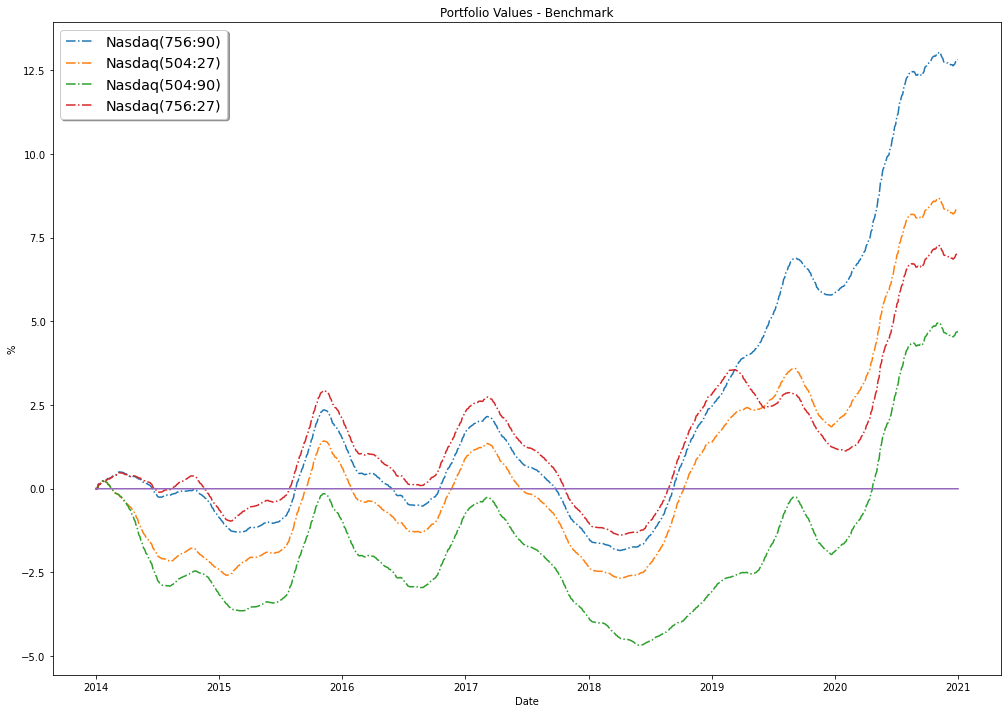

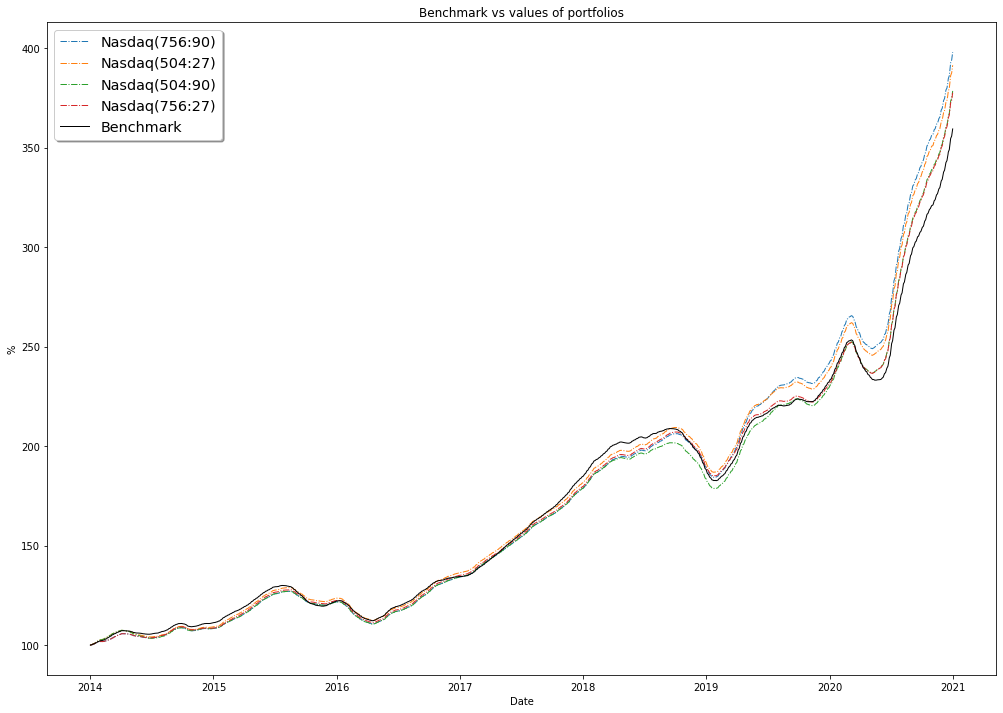

In [45]:
fig, ax = plt.subplots(figsize = (17, 12))
ax.plot(Date[D:], P, '-.', label = 'Nasdaq(756:90)')
ax.plot(Date[D:], R, '-.', label = 'Nasdaq(504:27)')
ax.plot(Date[D:], Z, '-.', label = 'Nasdaq(504:90)')
ax.plot(Date[D:], Alpha, '-.', label = 'Nasdaq(756:27)')
ax.plot(Date[D: ], [0 for i in range(len(Date[D: ]))])

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Portfolio Values - Benchmark')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')

fig, ax = plt.subplots(figsize = (17, 12))
ax.plot(Date[D:], O, '-.', linewidth = 1, label = 'Nasdaq(756:90)') 
ax.plot(Date[D:], L, '-.', linewidth = 1, label = 'Nasdaq(504:27)')
ax.plot(Date[D:], W, '-.', linewidth = 1, label = 'Nasdaq(504:90)')
ax.plot(Date[D:], Zeta, '-.', linewidth = 1, label = 'Nasdaq(756:27)') 
ax.plot(Date[D:], 100 * value_ben_avg[D:2610] / value_ben_avg[D], 'k', linewidth = 1, label = 'Benchmark') #Benchmark

plt.ylabel('%')
plt.xlabel('Date')
plt.title('Benchmark vs values of portfolios')
ax.legend(loc = 'upper left', shadow = True, fontsize = 'x-large')